In [117]:
import re

In [119]:
import pandas as pd
import numpy as np

df = pd.read_csv("Padded Data TS Morocco.csv", index_col=0)
df = df.applymap(lambda x: str(x).replace('\xa0', '').replace(' ', '') if isinstance(x, str) else x)
df = df.astype(np.float32)
df


C:\Users\khali\AppData\Local\Temp\ipykernel_19712\3134692170.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace('\xa0', '').replace(' ', '') if isinstance(x, str) else x)


IDE(USD)  REER(2010 = 100)  brent_oil_prices(USD/barrel)  \
1974-01-01 -2.040000e+07               NaN                      0.000000   
1974-02-01  0.000000e+00          0.000000                      0.000000   
1974-03-01  0.000000e+00          0.000000                      0.000000   
1974-04-01  0.000000e+00          0.000000                      0.000000   
1974-05-01  0.000000e+00          0.000000                      0.000000   
...                  ...               ...                           ...   
2021-09-01  0.000000e+00          0.000000                     71.989998   
2021-10-01  0.000000e+00          0.000000                     79.400002   
2021-11-01  0.000000e+00          0.000000                     84.510002   
2021-12-01  0.000000e+00          0.000000                     69.529999   
2022-01-01  2.294356e+09         99.879143                      0.000000   

            crude_oil_prices(USD/barrel)  daily_natural_gas_prices(USD/MMBtu)  \
1974-01-01                      0.000000                                  0.0   
1974-02-01                      0.000000                                  0.0   
1974-03-01                      0.000000                                  0.0   
1974-04-01                      0.000000                                  0.0   
1974-05-01                      0.000000                                  0.0   
...                                  ...                                  ...   
2021-09-01                     75.029999                                  0.0   
2021-10-01                     81.779999                                  0.0   
2021-11-01                     65.849998                                  0.0   
2021-12-01                     74.879997                                  0.0   
2022-01-01                     86.489998                                  0.0   

            annual_gold_prices(USD/oz)  wheat_production (Million Bushels)  \
1974-01-01                         0.0                         1781.900024   
1974-02-01                         0.0                            0.000000   
1974-03-01                         0.0                            0.000000   
1974-04-01                         0.0                            0.000000   
1974-05-01                         0.0                            0.000000   
...                                ...                                 ...   
2021-09-01                         0.0                            0.000000   
2021-10-01                         0.0                            0.000000   
2021-11-01                         0.0                            0.000000   
2021-12-01                         0.0                            0.000000   
2022-01-01                         0.0                         1649.713013   

            InterTourismeReceipts(usd)  \
1974-01-01                         NaN   
1974-02-01                0.000000e+00   
1974-03-01                0.000000e+00   
1974-04-01                0.000000e+00   
1974-05-01                0.000000e+00   
...                                ...   
2021-09-01                0.000000e+00   
2021-10-01                0.000000e+00   
2021-11-01                0.000000e+00   
2021-12-01                0.000000e+00   
2022-01-01                8.223000e+09   

            Inflation, prix à la consommation (% annuel)  \
1974-01-01                                     17.556822   
1974-02-01                                      0.000000   
1974-03-01                                      0.000000   
1974-04-01                                      0.000000   
1974-05-01                                      0.000000   
...                                                  ...   
2021-09-01                                      0.000000   
2021-10-01                                      0.000000   
2021-11-01                                      0.000000   
2021-12-01                                      0.000000   
2022-01-01                  

In [121]:
# Supprimer l'ancienne colonne "event" si elle existe
if "event" in df.columns:
    df.drop(columns=["event"], inplace=True)


In [123]:
df.index = pd.to_datetime(df.index)
# Structure de base : date, type, durée en mois, intensité max, forme
events = [
    {"date": "1973-03-01", "type": "good", "duration": 12, "peak": 0.6, "curve": "gaussian"},
    {"date": "1993-01-01", "type": "good", "duration": 5, "peak": 0.5, "curve": "exponential"},
    {"date": "2000-03-01", "type": "good", "duration": 8, "peak": 0.7, "curve": "exponential"},
    {"date": "2004-07-01", "type": "good", "duration": 6, "peak": 0.5, "curve": "exponential"},
    {"date": "2010-01-01", "type": "good", "duration": 9, "peak": 0.6, "curve": "linear"},
    {"date": "2019-01-01", "type": "good", "duration": 6, "peak": 0.5, "curve": "exponential"},
    
    {"date": "1981-05-01", "type": "bad", "duration": 6, "peak": 0.6, "curve": "gaussian"},
    {"date": "1984-01-01", "type": "bad", "duration": 12, "peak": 0.8, "curve": "linear"},
    {"date": "1995-01-01", "type": "bad", "duration": 6, "peak": 0.5, "curve": "exponential"},
    {"date": "1999-01-01", "type": "bad", "duration":3, "peak": 0.4, "curve": "gaussian"},
    {"date": "2007-01-01", "type": "bad", "duration": 10, "peak": 0.7, "curve": "gaussian"},
    {"date": "2011-01-01", "type": "bad", "duration": 4, "peak": 0.5, "curve": "gaussian"},
    {"date": "2020-03-01", "type": "bad", "duration": 18, "peak": 1.0, "curve": "gaussian"},
]

def linear_curve(peak, duration, step):
    return peak * (1 - step / duration)

def exponential_curve(peak, duration, step):
    return peak * np.exp(-2 * step / duration)

def gaussian_curve(peak, duration, step):
    center = duration / 2
    sigma = duration / 6  # + large = effet plus lissé
    return peak * np.exp(-((step - center) ** 2) / (2 * sigma ** 2))
def apply_event(df, event):
    start = pd.to_datetime(event["date"])
    duration = event["duration"]
    peak = event["peak"]
    etype = event["type"]
    curve = event["curve"]

    for m in range(duration):
        date = start + pd.DateOffset(months=m)
        if date in df.index:
            if curve == "linear":
                intensity = linear_curve(peak, duration, m)
            elif curve == "exponential":
                intensity = exponential_curve(peak, duration, m)
            elif curve == "gaussian":
                intensity = gaussian_curve(peak, duration, m)
            else:
                intensity = 0.0

            df.loc[date, "event"] += intensity if etype == "good" else -intensity


# Initialise la nouvelle colonne
df["event"] = 0.0

# Applique tous les événements
for ev in events:
    apply_event(df, ev)


In [125]:
import pandas as pd

# Suppose que df a un index de type datetime
# Vérifie cela avant (si nécessaire) :
# df.index = pd.to_datetime(df.index)

# Définir les listes d’indicateurs
monthly_indicators = [
    "brent_oil_prices(USD/barrel)", 
    "crude_oil_prices(USD/barrel)",
    "daily_natural_gas_prices(USD/MMBtu)"
]

sum_cols = [
    "IDE(USD)", 
    "REER(2010 = 100)",
    "annual_gold_prices(USD/oz)",
    "wheat_production (Million Bushels)", 
    "InterTourismeReceipts(usd)",
    "Consommation finals des ménages", 
    "Dépenses nationales brutes (unités de devises locales courantes)",
    "Exportation de biens et de services ($ US)", 
    "Importation de bien et de services ($ US)", 
    "Inflation, prix à la consommation (% annuel)", 
    "Chômage, total (% de la population)",
    "Chômage, total jeune entre 15-24 (% de la population)", 
    "Pauvrete", 
    "Analphabetisme",
    "Demographie"
]

# Initialisation du dataframe annuel vide
df_annual = pd.DataFrame()

# Agrégation des indicateurs mensuels
for indicator in monthly_indicators:
    if indicator in df.columns:
        df_annual[f"mean_{indicator}"] = df[indicator].resample("Y").mean()
        df_annual[f"sum_{indicator}"] = df[indicator].resample("Y").sum()
        df_annual[f"volatilite_{indicator}"] = df[indicator].resample("Y").std()

# Agrégation des autres colonnes à sommer
other_sum_cols = [col for col in sum_cols if col not in monthly_indicators and col in df.columns]
if other_sum_cols:
    df_sum = df[other_sum_cols].resample("Y").sum()
    df_annual = pd.concat([df_annual, df_sum], axis=1)

# Traitement spécial de la colonne 'event'
if "event" in df.columns:
    # Étape 1 : impact cumulé de l'événement par année
    df_event_sum = df["event"].resample("Y").sum()

    # Étape 2 : intensité moyenne annuelle par mois (normalisation systématique sur 12 mois)
    df_event = df_event_sum / 6
    df_event = df_event.to_frame(name="event")

    # Ajout à df_annual
    df_annual = pd.concat([df_annual, df_event], axis=1)


# Réindexer par année uniquement
df_annual.index = df_annual.index.year




C:\Users\khali\AppData\Local\Temp\ipykernel_19712\2868174444.py:38: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_annual[f"mean_{indicator}"] = df[indicator].resample("Y").mean()
C:\Users\khali\AppData\Local\Temp\ipykernel_19712\2868174444.py:39: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_annual[f"sum_{indicator}"] = df[indicator].resample("Y").sum()
C:\Users\khali\AppData\Local\Temp\ipykernel_19712\2868174444.py:40: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_annual[f"volatilite_{indicator}"] = df[indicator].resample("Y").std()
C:\Users\khali\AppData\Local\Temp\ipykernel_19712\2868174444.py:38: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_annual[f"mean_{indicator}"] = df[indicator].resample("Y").mean()
C:\Users\khali\AppData\Local\Temp\ipykernel_19712

In [127]:
df_annual.head(50)

mean_brent_oil_prices(USD/barrel)  sum_brent_oil_prices(USD/barrel)  \
1974                           0.000000                          0.000000   
1975                           0.000000                          0.000000   
1976                           0.000000                          0.000000   
1977                           0.000000                          0.000000   
1978                           0.000000                          0.000000   
1979                           0.000000                          0.000000   
1980                           0.000000                          0.000000   
1981                           0.000000                          0.000000   
1982                           0.000000                          0.000000   
1983                           0.000000                          0.000000   
1984                           0.000000                          0.000000   
1985                           0.000000                          0.000000   
1986                           0.000000                          0.000000   
1987                           7.684166                         92.209999   
1988                           9.785000                        117.419998   
1989                          10.266666                        123.199997   
1990                          13.858334                        166.300003   
1991                          13.314167                        159.770004   
1992                          11.514167                        138.169998   
1993                          12.992500                        155.910004   
1994                          10.997500                        131.970001   
1995                          11.420001                        137.040009   
1996                          13.264167                        159.169998   
1997                           7.800000                         93.599998   
1998                           7.529167                         90.349998   
1999                          13.083333                        157.000000   
2000                          17.530001                        210.360001   
2001                          14.411667                        172.940002   
2002                          16.741667                        200.899994   
2003                          16.289999                        195.479996   
2004                          26.367500                        316.410004   
2005                          41.190834                        494.290009   
2006                          44.740833                        536.890015   
2007                          41.647503                        499.770020   
2008                          58.500000                        702.000000   
2009                          37.280834                        447.369995   
2010                          58.827499                        705.929993   
2011                          83.911667                       1006.940002   
2012                          65.343330                        784.119995   
2013                          71.584999                        859.020020   
2014                          49.505001                        594.059998   
2015                          31.969168                        383.630005   
2016                          32.027500                        384.329987   
2017                          36.816666                        441.799988   
2018                          42.557499                        510.690002   
2019                          42.907501                        514.890015   
2020                          26.054167                        312.649994   
2021                          53.081665                        636.979980   
2022                           0.000000                          0.000000   

      volatilite_brent_oil_prices(USD/barrel)  \
1974                                 0.000000   
1975                                 0.000000   
1976    

In [257]:
# Filtrer les lignes dont l'index (les années) est entre 1985 et 2022
MEco = df_annual.loc[1985:2021]

# Enregistrer le DataFrame filtré dans un fichier CSV
MEco.to_csv("MEco.csv")


In [129]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Configuration globale pour un style plus professionnel
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

# Création de palettes de couleurs personnalisées
good_cmap = LinearSegmentedColormap.from_list("custom_green", ["#D5F5E3", "#1E8449"])
bad_cmap = LinearSegmentedColormap.from_list("custom_red", ["#FADBD8", "#922B21"])

def get_event_color(intensity, alpha=0.8):
    """Retourne une couleur avec transparence basée sur l'intensité"""
    if intensity > 0.05:
        return good_cmap(min(abs(intensity), 1.0))
    elif intensity < -0.05:
        return bad_cmap(min(abs(intensity), 1.0))
    else:
        return (0.7, 0.7, 0.7, alpha)  # Gris avec transparence

def get_event_label(intensity):
    """Génère un label formaté selon l'intensité de l'événement"""
    if intensity > 0.05:
        return f"Événement positif ({intensity:.2f})"
    elif intensity < -0.05:
        return f"Événement négatif ({abs(intensity):.2f})"
    else:
        return "Période normale"

def visualize_economic_indicator(df, indicator, events_column="event", figsize=(14, 7)):
    """
    Visualisation améliorée d'un indicateur économique annuel avec les événements associés.
    
    Args:
        df: DataFrame avec un index d'années (int) et des colonnes économiques
        indicator: Colonne à visualiser
        events_column: Colonne des intensités d'événements
        figsize: Taille de la figure
    """
    if indicator not in df.columns or events_column not in df.columns:
        print(f"Indicateur ou colonne d'événement manquant: {indicator}, {events_column}")
        return

    # Masquer les valeurs invalides
    mask_valid = df[indicator].replace(0, np.nan).notna()
    df_valid = df[mask_valid].copy()
    
    if df_valid.empty:
        print(f"Aucune donnée valide pour {indicator}")
        return

    # Utiliser directement les années comme axe X (sans conversion en datetime)
    years = df_valid.index.astype(int)  # Assurez-vous que l'index est bien en int

    # Normalisation
    normalized = (df_valid[indicator] - df_valid[indicator].min()) / \
                 (df_valid[indicator].max() - df_valid[indicator].min())
    
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Tracer l'indicateur
    ax1.plot(years, df_valid[indicator], label=indicator, color='#3498DB', linewidth=2.5, zorder=5)

    # Ajouter les marqueurs d'événements
    events_to_plot = {}
    for i, year in enumerate(years):
        intensity = df_valid[events_column].iloc[i]
        if abs(intensity) > 0.05:
            color = get_event_color(intensity)
            label = get_event_label(intensity)
            size = 80 + abs(intensity) * 100
            y_val = df_valid[indicator].iloc[i]
            
            if label not in events_to_plot:
                ax1.scatter(year, y_val, color=color, label=label, s=size,
                            edgecolor='black', linewidth=1, alpha=0.8, zorder=10)
                events_to_plot[label] = True
            else:
                ax1.scatter(year, y_val, color=color, s=size,
                            edgecolor='black', linewidth=1, alpha=0.8, zorder=10)

    # Axe secondaire : intensité
    ax2 = ax1.twinx()
    ax2.fill_between(years, df_valid[events_column], 0,
                     where=df_valid[events_column] > 0, color='green', alpha=0.2, label="Impact positif")
    ax2.fill_between(years, df_valid[events_column], 0,
                     where=df_valid[events_column] < 0, color='red', alpha=0.2, label="Impact négatif")
    ax2.set_ylabel("Intensité des événements", fontsize=12)
    ax2.set_ylim(-1.1, 1.1)
    
    # Axes
    ax1.set_title(f"Évolution de {indicator} et événements économiques", fontsize=16, pad=20)
    ax1.set_xlabel("Année", fontsize=12)
    ax1.set_ylabel(indicator, fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Configuration pour les années sur l'axe X
    ax1.set_xticks(years)
    ax1.set_xticklabels(years)
    
    # Espacement des graduations en fonction du nombre d'années
    if len(years) > 15:
        # Afficher une année sur deux ou trois si trop d'années
        interval = 2 if len(years) <= 30 else 3
        for idx, label in enumerate(ax1.xaxis.get_ticklabels()):
            if idx % interval != 0:
                label.set_visible(False)
    
    # Rotation des étiquettes d'années pour éviter les chevauchements
    plt.xticks(rotation=45)
    
    # Légende combinée
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc='best', frameon=True, framealpha=0.9,
               bbox_to_anchor=(1.15, 1))
    
    # Annotations importantes
    for i, year in enumerate(years):
        intensity = df_valid[events_column].iloc[i]
        if abs(intensity) > 0.5:
            ax1.annotate(f"{intensity:.2f}",
                         xy=(year, df_valid[indicator].iloc[i]),
                         xytext=(10, 10 if intensity > 0 else -20),
                         textcoords="offset points",
                         arrowprops=dict(arrowstyle="->", color='black', alpha=0.6),
                         fontsize=9,
                         bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='gray', alpha=0.8))
    
    plt.tight_layout()
    return fig, ax1, ax2

# Application à tous les indicateurs économiques
def visualize_all_indicators(df, indicators, events_column="event"):
    """
    Visualise tous les indicateurs économiques spécifiés
    
    Args:
        df: DataFrame contenant les données
        indicators: Liste des noms de colonnes à visualiser
        events_column: Nom de la colonne contenant les intensités d'événements
    """
    figures = {}
    
    for indicator in indicators:
        print(f"Visualisation de {indicator}...")
        fig, ax1, ax2 = visualize_economic_indicator(df, indicator, events_column)
        plt.show()
        figures[indicator] = (fig, ax1, ax2)
    
    return figures

Visualisation de IDE(USD)...


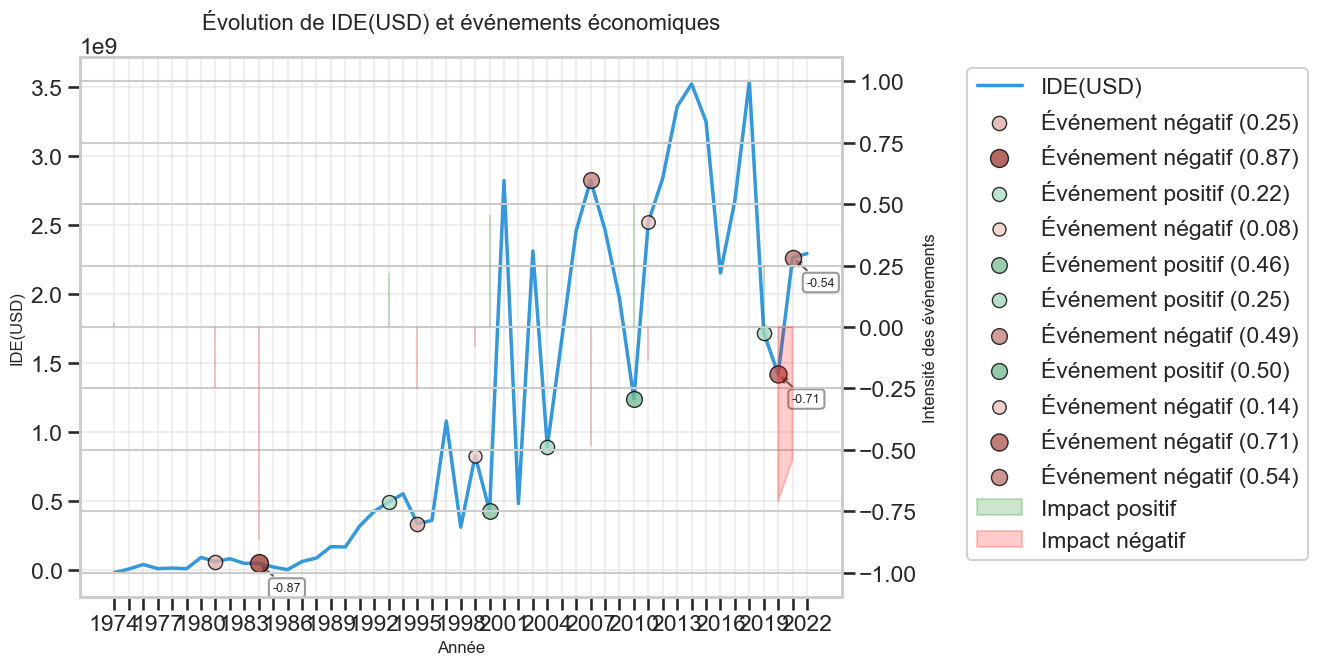

Visualisation de REER(2010 = 100)...


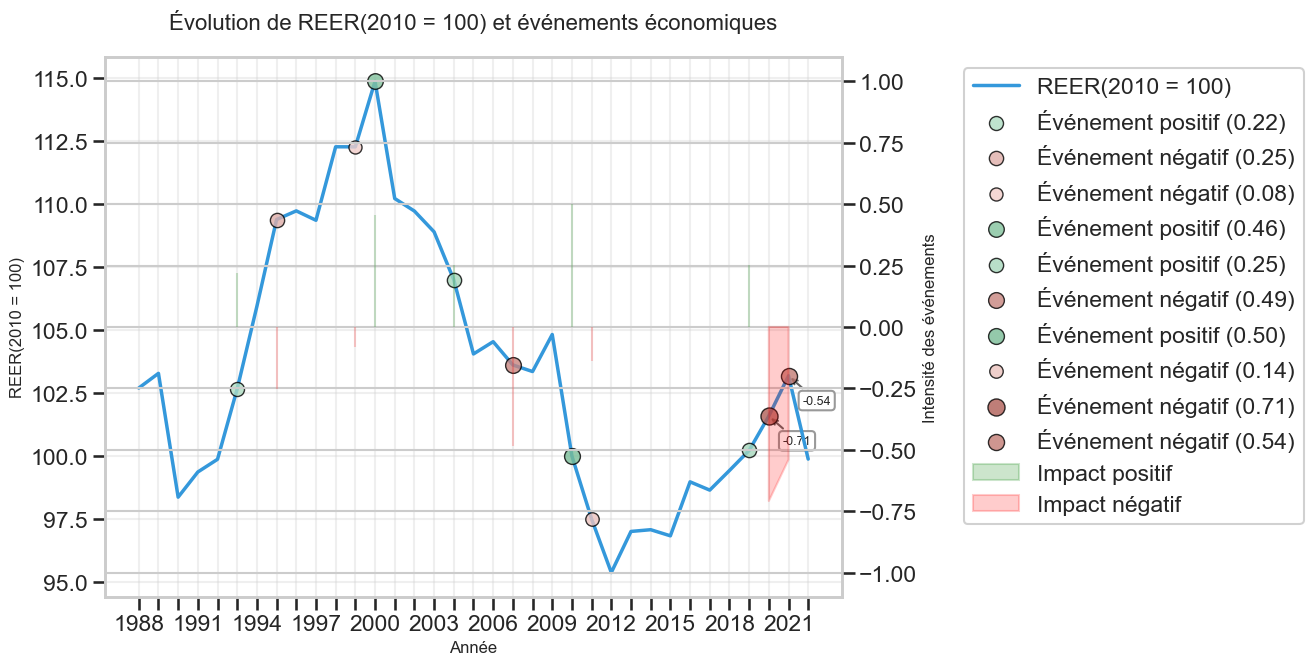

Visualisation de mean_brent_oil_prices(USD/barrel)...


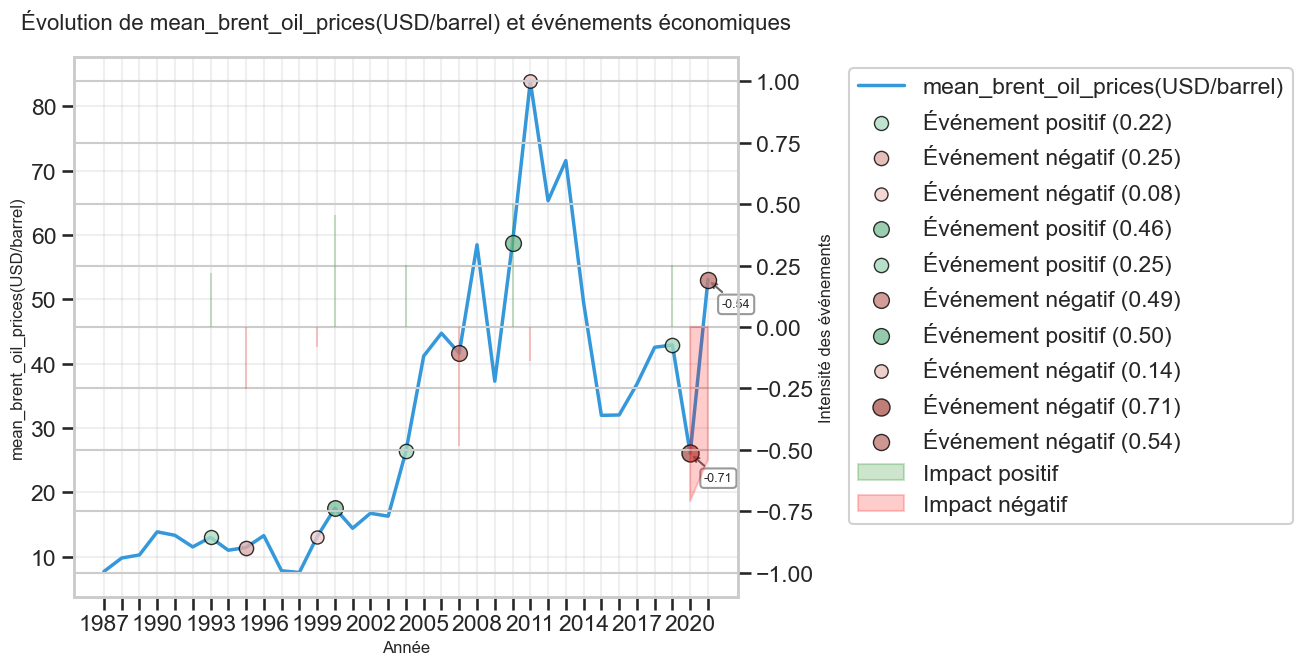

Visualisation de mean_crude_oil_prices(USD/barrel)...


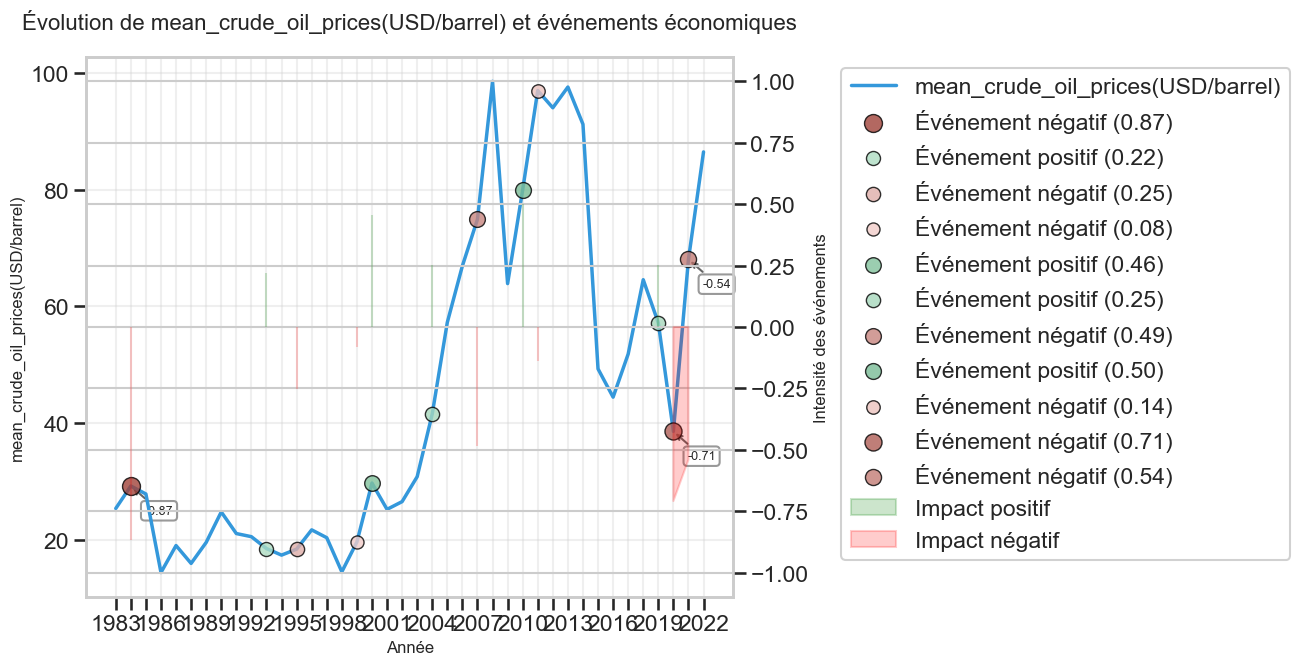

Visualisation de mean_daily_natural_gas_prices(USD/MMBtu)...


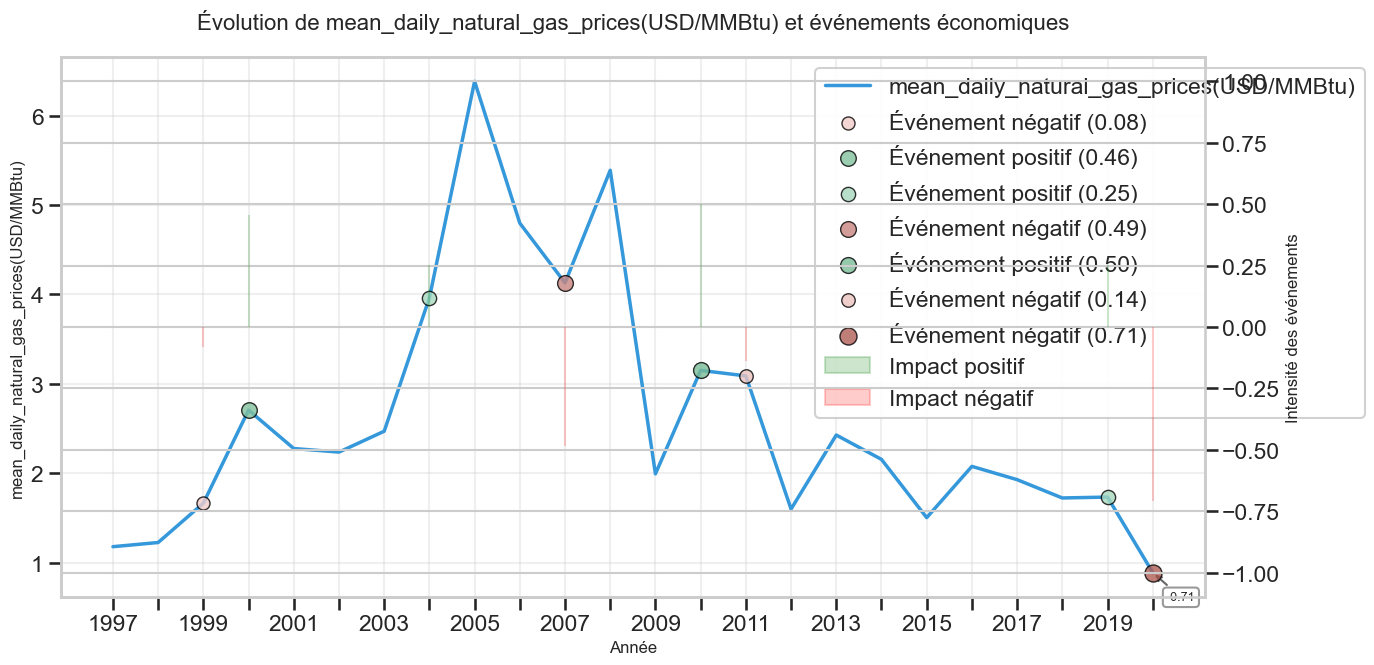

Visualisation de annual_gold_prices(USD/oz)...


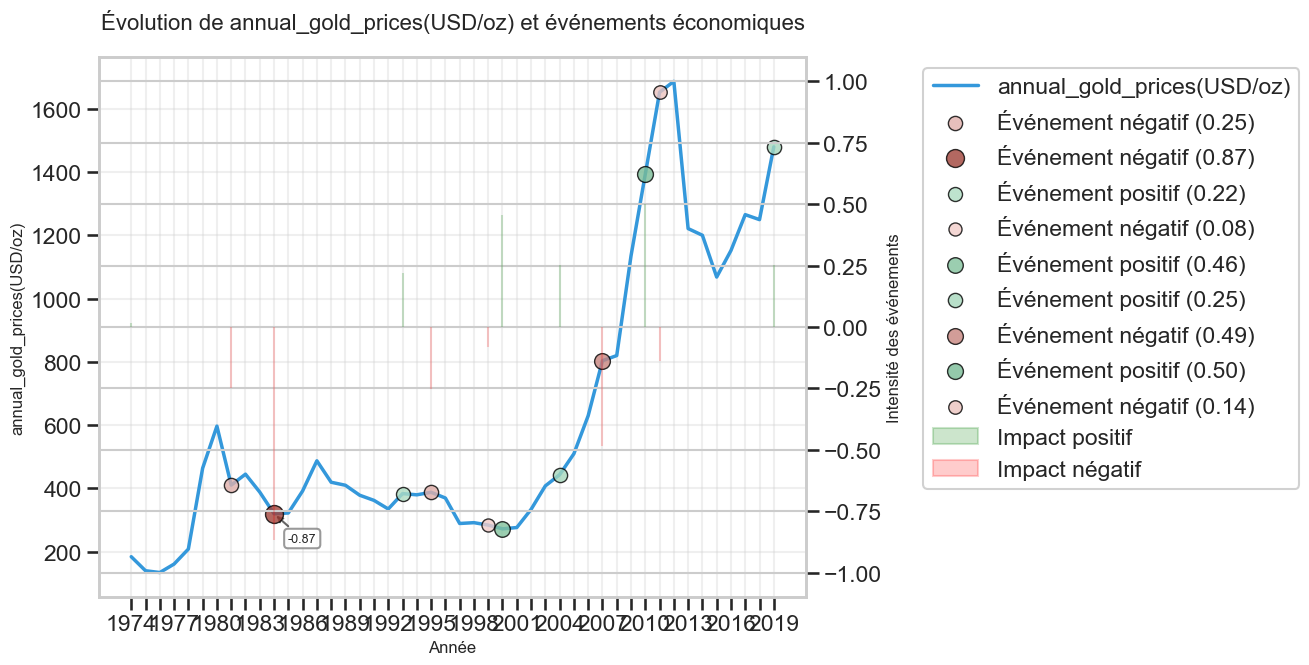

Visualisation de InterTourismeReceipts(usd)...


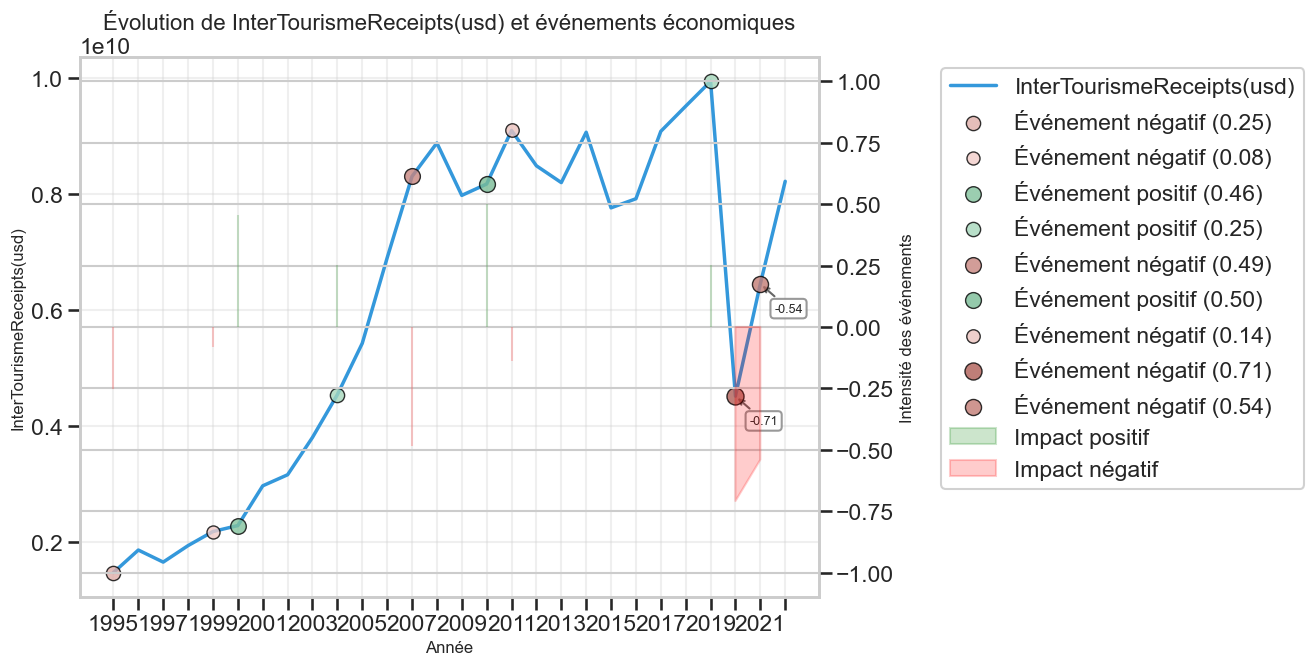

Visualisation de Exportation de biens et de services ($ US)...


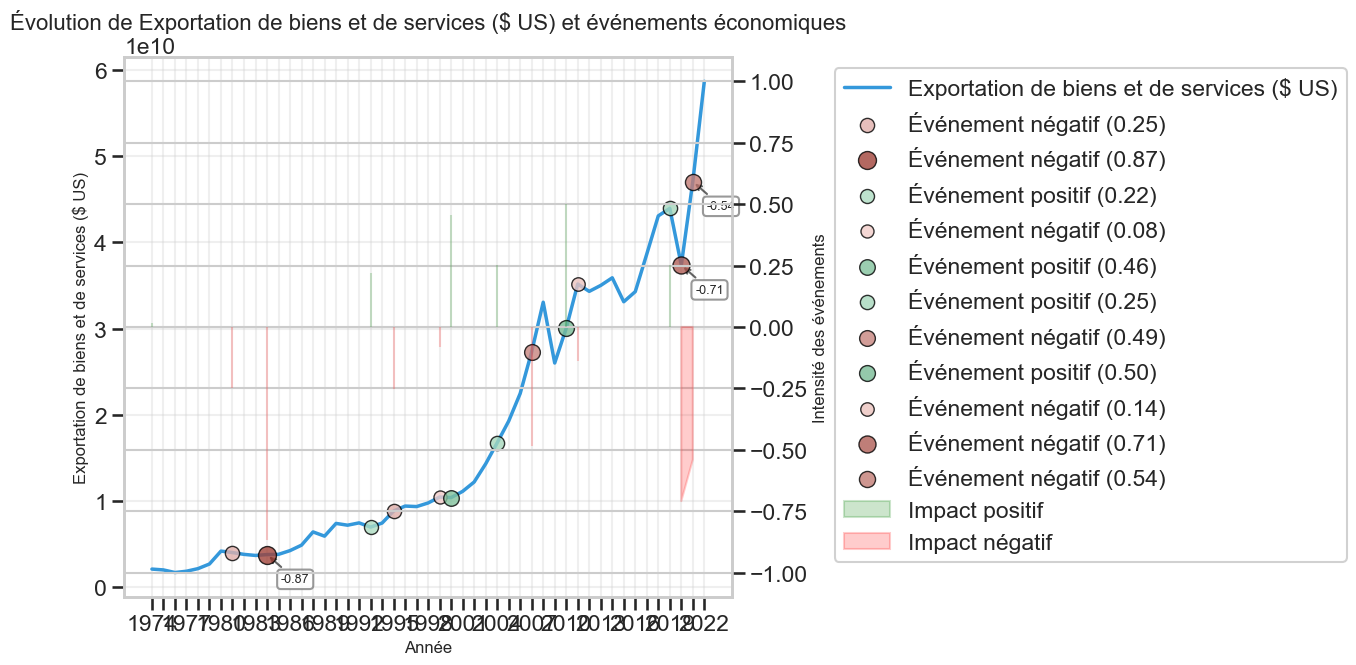

Visualisation de Importation de bien et de services ($ US)...


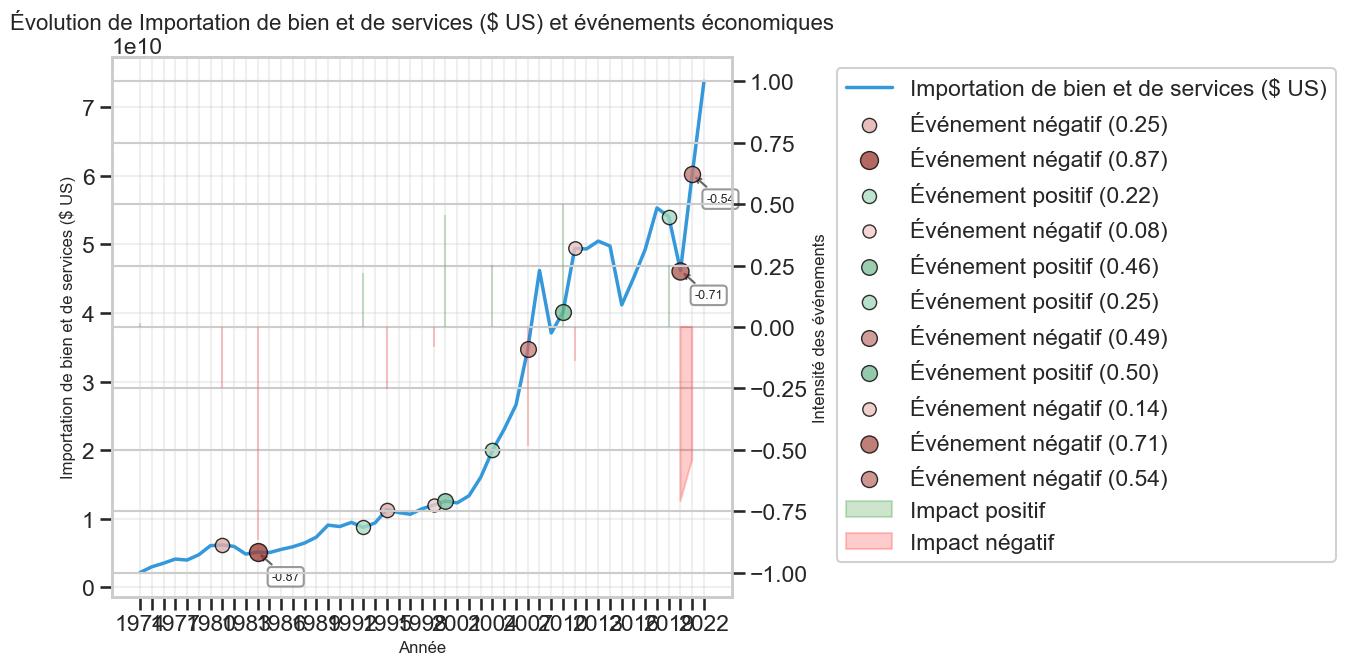

Visualisation de Dépenses nationales brutes (unités de devises locales courantes)...


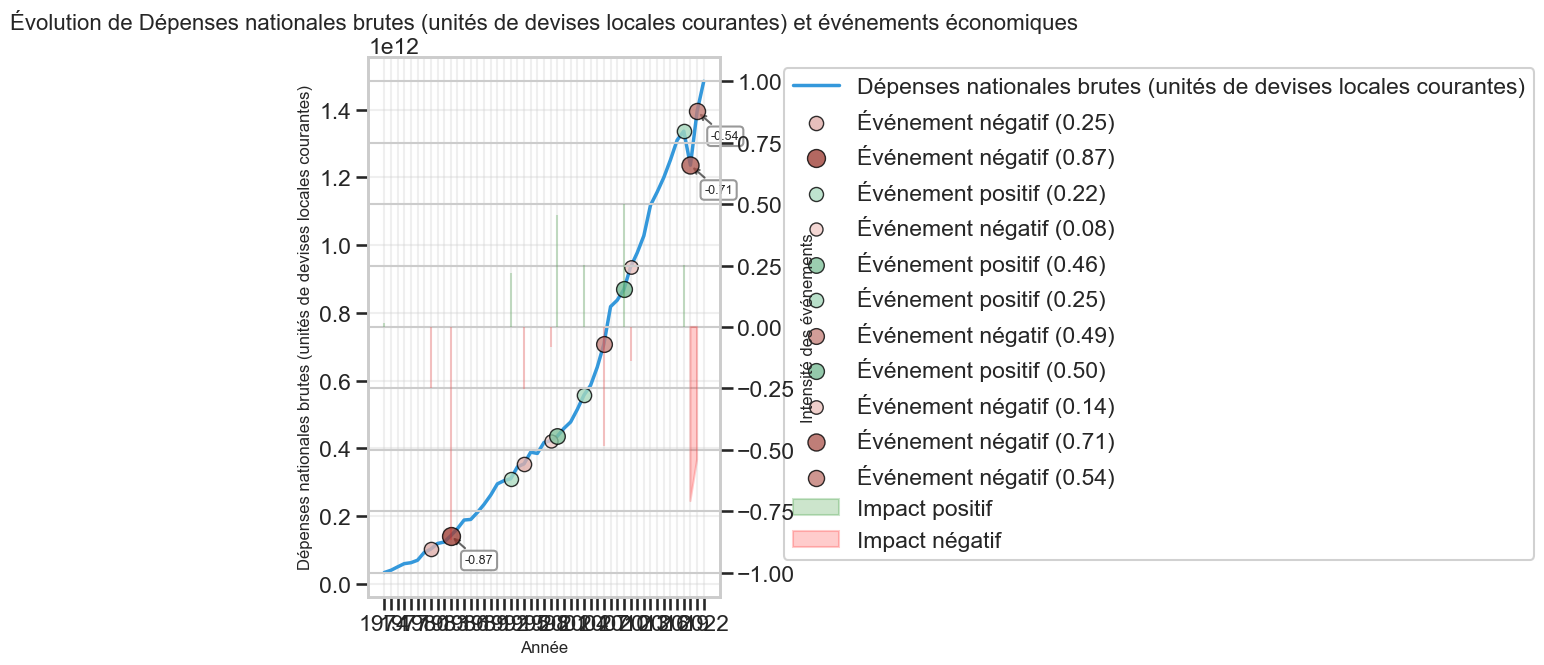

In [131]:
# Appel avec df_annual
if __name__ == "__main__":
    economic_indicators = [
        'IDE(USD)', 'REER(2010 = 100)', 'mean_brent_oil_prices(USD/barrel)',
        'mean_crude_oil_prices(USD/barrel)', 'mean_daily_natural_gas_prices(USD/MMBtu)',
        'annual_gold_prices(USD/oz)', 'InterTourismeReceipts(usd)',
        'Exportation de biens et de services ($ US)',
        'Importation de bien et de services ($ US)',
        'Dépenses nationales brutes (unités de devises locales courantes)'
    ]
    
    figs = visualize_all_indicators(df_annual, economic_indicators)


In [141]:
economic_indicators = [
           'IDE(USD)', 'REER(2010 = 100)', 'mean_brent_oil_prices(USD/barrel)',
        'mean_crude_oil_prices(USD/barrel)', 'mean_daily_natural_gas_prices(USD/MMBtu)',
        'annual_gold_prices(USD/oz)', 'InterTourismeReceipts(usd)',
        'Exportation de biens et de services ($ US)',
        'Importation de bien et de services ($ US)',
        'Dépenses nationales brutes (unités de devises locales courantes)'
]
demographic_indicators = [
    'Demographie', 'Pauvrete', 'Analphabetisme'
]
rate_indicators = [
    'Inflation, prix à la consommation (%\xa0annuel)',
    'Chômage, total (%\xa0de la population)',
    'Chômage, total jeune entre 15-24  (%\xa0de la population)'
]
production_indicators = ['wheat_production (Million Bushels)']
consumption_indicators = ['Consommation finals des ménages']

In [78]:
!pip install optuna


In [133]:
import optuna
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [135]:
def build_optimized_gru_attention_model(input_shape, output_shape=1, params=None):
    """
    Build an optimized GRU model with attention mechanism for time series forecasting (no masking).
    
    Args:
        input_shape (tuple): Shape of the input data (timesteps, features)
        output_shape (int): Number of output features to predict
        params (dict): Hyperparameters for model configuration
        
    Returns:
        tf.keras.Model: Compiled model with attention mechanism
    """
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers

    # Default parameters
    if params is None:
        params = {
            'gru_units': 64,
            'dropout_rate': 0.2,
            'recurrent_dropout': 0.1,
            'l2_reg': 0.001,
            'dense_units': 32,
            'learning_rate': 0.001,
            'use_bidirectional': True
        }
    from keras.saving import register_keras_serializable

    @register_keras_serializable()
    # Custom attention layer
    class AttentionLayer(layers.Layer):
        def __init__(self, **kwargs):
            super(AttentionLayer, self).__init__(**kwargs)

        def build(self, input_shape):
            self.dense_attention = layers.Dense(1, use_bias=False)
            self.softmax = layers.Softmax(axis=1)
            super(AttentionLayer, self).build(input_shape)

        def call(self, inputs):
            attention_scores = self.dense_attention(inputs)
            attention_weights = self.softmax(attention_scores)
            context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)
            return context_vector

    # Input
    sequence_input = keras.Input(shape=input_shape, name='sequence_input')

    # GRU layer
    gru_layer = layers.GRU(
        params['gru_units'],
        return_sequences=True,
        recurrent_dropout=params['recurrent_dropout'],
        kernel_regularizer=keras.regularizers.l2(params['l2_reg']),
        recurrent_regularizer=keras.regularizers.l2(params['l2_reg'])
    )

    if params.get('use_bidirectional', True):
        x = layers.Bidirectional(gru_layer)(sequence_input)
    else:
        x = gru_layer(sequence_input)

    x = layers.LayerNormalization()(x)
    x = layers.Dropout(params['dropout_rate'])(x)

    # Attention
    context_vector = AttentionLayer(name='attention_layer')(x)

    # Exogenous input
    exog_input = keras.Input(shape=(1,), name='exog_input')
    exog_processed = layers.Dense(8, activation='relu')(exog_input)
    exog_processed = layers.BatchNormalization()(exog_processed)

    # Combine
    combined = layers.Concatenate()([context_vector, exog_processed])

    # Dense layers
    x = layers.Dense(
        params['dense_units'],
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(params['l2_reg'])
    )(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(params['dropout_rate'] / 2)(x)

    x = layers.Dense(
        params['dense_units'] // 2,
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(params['l2_reg'])
    )(x)
    x = layers.BatchNormalization()(x)

    # Output
    output = layers.Dense(output_shape, activation='linear', name='output')(x)

    # Model
    model = keras.Model(inputs=[sequence_input, exog_input], outputs=output)

    

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='mse',
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
     )

    return model


In [145]:
### 2. Fonction preprocess_data - Améliorations

def preprocess_data(df, indicator_list, seq_length=10, test_size=0.2, random_state=42):
    """
    Preprocess the time series data for supervised learning with improved handling of outliers
    and different scales.
    
    Args:
        df (pd.DataFrame): Raw time series dataframe
        indicator_list (list): List of column names to use as target variables
        seq_length (int): Length of the input sequences (timesteps)
        test_size (float): Fraction of data to reserve for testing
        random_state (int): Seed for reproducibility
        
    Returns:
        X_train, X_test, y_train, y_test, target_scaler
    """
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler, RobustScaler
    from sklearn.model_selection import train_test_split
    import warnings
    
    df_processed = df.copy()
    
    # Identify and handle outliers in each indicator using IQR
    for col in indicator_list:
        if pd.api.types.is_numeric_dtype(df_processed[col]):
            # Calculate IQR
            Q1 = df_processed[col].quantile(0.25)
            Q3 = df_processed[col].quantile(0.75)
            IQR = Q3 - Q1
            
            # Define bounds for outliers (1.5 IQR method)
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Cap outliers instead of removing them
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                df_processed[col] = df_processed[col].clip(lower_bound, upper_bound)

    # Handle missing values for all columns
    for column in df_processed.columns:
        if df_processed[column].isna().any():
            # Forward fill then backward fill to handle missing values in time series
            df_processed[column] = df_processed[column].ffill().bfill()
            
            # If still has NaN, use median for numeric columns
            if df_processed[column].isna().any() and pd.api.types.is_numeric_dtype(df_processed[column]):
                median_value = df_processed[column].median()
                df_processed[column] = df_processed[column].fillna(median_value)
    
    # Consider logarithmic transformation for highly skewed features
    for col in indicator_list:
        if pd.api.types.is_numeric_dtype(df_processed[col]) and df_processed[col].min() > 0:
            # Check skewness
            skewness = df_processed[col].skew()
            if abs(skewness) > 1.5:  # High skewness threshold
                # Apply log transformation to reduce skewness
                df_processed[f"{col}_log"] = np.log1p(df_processed[col])
                # Replace original column with log-transformed version in indicator list
                # You may want to keep track of which columns were transformed for inverse transform later
    
    # Extract and normalize target indicators - using RobustScaler for better handling of scale differences
    target = df_processed[indicator_list]
    target_scaler = RobustScaler()  # Changed from MinMaxScaler for better robustness to outliers
    normalized_target = target_scaler.fit_transform(target)
    
    # Create sequences
    X, y = [], []
    for i in range(len(normalized_target) - seq_length):
        X.append(normalized_target[i:i + seq_length])
        y.append(normalized_target[i + seq_length])
    
    X = np.array(X)
    y = np.array(y)
    
    # Train/test split (no shuffle for time series)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=False
    )
    
    return X_train, X_test, y_train, y_test, target_scaler


In [147]:
# Suppose que tu as déjà importé ton DataFrame "df" et la liste des indicateurs "indicator_list"
X_train, X_test, y_train, y_test, target_scaler = preprocess_data(df_annual, economic_indicators)

# Affichage des shapes
print("Shapes des ensembles :")
print(f"X_train : {X_train.shape}")
print(f"X_test  : {X_test.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_test  : {y_test.shape}")

# Affichage d'exemples
print("\nExemple de séquence X_train[0] :")
print(X_train[0])

print("\nExemple de target y_train[0] :")
print(y_train[0])


Shapes des ensembles :
X_train : (31, 10, 10)
X_test  : (8, 10, 10)
y_train : (31, 10)
y_test  : (8, 10)

Exemple de séquence X_train[0] :
[[-0.23110875 -0.95539971 -0.35579051 -0.63654027  0.         -0.40587124
  -0.24413027 -0.2662393  -0.26469412 -0.56399943]
 [-0.21963156 -0.95539971 -0.35579051 -0.63654027  0.         -0.4925536
  -0.24413027 -0.26957014 -0.24097951 -0.55427588]
 [-0.20473425 -0.95539971 -0.35579051 -0.63654027  0.         -0.50349531
  -0.24413027 -0.28005857 -0.22604217 -0.53964655]
 [-0.21828877 -0.95539971 -0.35579051 -0.63654027  0.         -0.45116652
  -0.24413027 -0.27485345 -0.2088396  -0.52553919]
 [-0.21658844 -0.95539971 -0.35579051 -0.63654027  0.         -0.35860626
  -0.24413027 -0.2644374  -0.21293692 -0.52144812]
 [-0.21854003 -0.95539971 -0.35579051 -0.63654027  0.          0.14069192
  -0.24413027 -0.24570318 -0.19093923 -0.51070632]
 [-0.18152646 -0.95539971 -0.35579051 -0.63654027  0.          0.40041498
  -0.24413027 -0.19381154 -0.15294495 

In [149]:
### 3. Fonction objective - Améliorations

def objective(trial, df, indicator_list, exog_col='event'):
    """
    Objective function for Optuna hyperparameter optimization, updated for the optimized GRU model.
    
    Args:
        trial: Optuna trial object
        df: DataFrame containing the data
        indicator_list: List of indicators to predict
        exog_col: Column name for exogenous variable
        
    Returns:
        float: Validation loss value for this trial
    """
    import numpy as np
    import tensorflow as tf
    from tensorflow import keras
    import pandas as pd
    
    # Define hyperparameters to optimize with expanded parameters for optimized model
    params = {
        'gru_units': trial.suggest_int('gru_units', 32, 256),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
        'recurrent_dropout': trial.suggest_float('recurrent_dropout', 0.0, 0.3),
        'l2_reg': trial.suggest_float('l2_reg', 1e-5, 1e-2, log=True),
        'dense_units': trial.suggest_int('dense_units', 16, 128),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128]),
        'seq_length': trial.suggest_int('seq_length', 6, 24),
        'use_bidirectional': trial.suggest_categorical('use_bidirectional', [True, False]),
    }
    
    # Extract exogenous variable safely
    if exog_col in df.columns:
        exog_data = df[exog_col].values
    else:
        print(f"Warning: Exogenous column '{exog_col}' not found. Using zeros.")
        exog_data = np.zeros(len(df))
    
    # Preprocess the data
    try:
        X_train, X_test, y_train, y_test, target_scaler = preprocess_data(
            df, indicator_list, seq_length=params['seq_length']
        )
    except Exception as e:
        print(f"Preprocessing failed: {e}")
        return float('inf')
    
    # Align exogenous data with X/y
    offset = params['seq_length']
    
    # Safely extract exogenous data with proper bounds checking
    if offset + len(X_train) <= len(exog_data):
        exog_train = exog_data[offset:offset + len(X_train)]
    else:
        print("Warning: Exogenous train data length mismatch. Padding with zeros.")
        exog_train = np.zeros(len(X_train))
    
    if offset + len(X_train) + len(X_test) <= len(exog_data):
        exog_test = exog_data[offset + len(X_train):offset + len(X_train) + len(X_test)]
    else:
        print("Warning: Exogenous test data length mismatch. Padding with zeros.")
        exog_test = np.zeros(len(X_test))
    
   
    # If data became empty after filtering, return high loss
    if len(X_train) < 10 or len(X_test) < 5:  # Minimum viable dataset size
        print("Data became too small after filtering")
        return float('inf')
    
    # Reshape exogenous variables
    exog_train = exog_train.reshape(-1, 1)
    exog_test = exog_test.reshape(-1, 1)
    
    # Set custom pruning threshold based on dataset size
    pruning_threshold = np.mean(np.var(y_train, axis=0)) * 10  # Adaptive threshold based on data variance
    
    # Build and compile the model using the optimized version
    try:
        with tf.device('/CPU:0'):  # Force CPU usage for trials to prevent GPU memory issues
            model = build_optimized_gru_attention_model(
                input_shape=(X_train.shape[1], X_train.shape[2]),
                output_shape=y_train.shape[1],
                params=params
            )
    except Exception as e:
        print(f"Model building failed: {e}")
        return float('inf')
    
    # Set up early stopping with appropriate patience
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    # Train the model with error handling
    try:
        history = model.fit(
            [X_train, exog_train],
            y_train,
            validation_data=([X_test, exog_test], y_test),
            epochs=50,
            batch_size=params['batch_size'],
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Get best validation loss
        best_val_loss = min(history.history['val_loss'])
        
        # Check for NaN loss
        if np.isnan(best_val_loss):
            print("Training produced NaN loss")
            return float('inf')
        
        # Check if model is performing significantly worse than baseline
        if best_val_loss > pruning_threshold:
            print(f"Trial pruned: validation loss {best_val_loss} exceeds threshold {pruning_threshold}")
            return float('inf')
        
        return best_val_loss
        
    except Exception as e:
        print(f"Training failed: {e}")
        return float('inf')

In [155]:
def optimize_hyperparameters(df, indicator_list, exog_col='event', n_trials=50):
    """
    Run Optuna hyperparameter optimization with improved search strategy
    """
    import optuna
    import functools
    
    # Enable logging for better debugging
    import logging
    optuna.logging.get_logger("optuna").setLevel(logging.INFO)
    
    # Create a study object with better sampler
    sampler = optuna.samplers.TPESampler(
        seed=42,
        # Suppression du paramètre multivariate qui cause un avertissement
        consider_magic_clip=True,
        consider_endpoints=True,
        n_startup_trials=10
    )
    
    pruner = optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=0,
        interval_steps=1
    )
    
    study = optuna.create_study(
        direction='minimize',
        sampler=sampler,
        pruner=pruner
    )
    
    # Create a partial function to pass additional arguments to objective
    objective_func = functools.partial(
        objective, 
        df=df, 
        indicator_list=indicator_list, 
        exog_col=exog_col
    )
    
    # Run optimization
    study.optimize(objective_func, n_trials=n_trials)
    
    # Print optimization results
    print(f"\nBest trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value:.4f}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    # Visualize the optimization results (optional)
    try:
        from IPython.display import display
        fig = optuna.visualization.plot_param_importances(study)
        display(fig)
    except:
        print("Could not display parameter importances visualization")
    
    return study


In [157]:
### 4. Fonction train_model_with_best_params - Améliorations

def train_model_with_best_params(df, indicator_list, study, exog_col='event', epochs=100):
    """
    Train the model with the best hyperparameters found by Optuna, using the optimized model.
    
    Args:
        df: DataFrame containing the data
        indicator_list: List of indicators to predict
        study: Optuna study object with best parameters
        exog_col: Column name for exogenous variable
        epochs: Number of training epochs
        
    Returns:
        Various training results and model objects
    """
    import numpy as np
    import tensorflow as tf
    from tensorflow import keras
    import matplotlib.pyplot as plt
    import os
    
    # Get the best parameters
    best_params = study.best_params
    
    # Extract exogenous variable with safe fallback
    if exog_col in df.columns:
        exog_data = df[exog_col].values
    else:
        print(f"Warning: Exogenous column '{exog_col}' not found. Using zeros.")
        exog_data = np.zeros(len(df))
    
    # Preprocess data using the best sequence length
    X_train, X_test, y_train, y_test, target_scaler = preprocess_data(
        df, indicator_list, seq_length=best_params['seq_length']
    )
    
    # Prepare exogenous data for training and testing with bounds checking
    offset = best_params['seq_length']
    if offset + len(X_train) <= len(exog_data):
        exog_train = exog_data[offset:offset + len(X_train)]
    else:
        print("Warning: Exogenous train data length mismatch. Padding with zeros.")
        exog_train = np.zeros(len(X_train))
    
    if offset + len(X_train) + len(X_test) <= len(exog_data):
        exog_test = exog_data[offset + len(X_train):offset + len(X_train) + len(X_test)]
    else:
        print("Warning: Exogenous test data length mismatch. Padding with zeros.")
        exog_test = np.zeros(len(X_test))
    
    
    # Reshape exogenous data
    exog_train = exog_train.reshape(-1, 1)
    exog_test = exog_test.reshape(-1, 1)
    
    # Print dataset shapes for verification
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    print(f"exog_train shape: {exog_train.shape}, exog_test shape: {exog_test.shape}")
    
    # Define a checkpoint directory with timestamp for better organization
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    checkpoint_dir = f'checkpoints_{timestamp}'
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Build the optimized model with the best hyperparameters
    model = build_optimized_gru_attention_model(
        input_shape=(X_train.shape[1], X_train.shape[2]), 
        output_shape=y_train.shape[1], 
        params=best_params
    )
    
    # Display model summary
    model.summary()
    
    # Early stopping callback with increased patience
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )
    
    # Add learning rate reducer with better scheduling
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,  # Increased from 5
        min_lr=1e-6,
        verbose=1
    )
    
    # Add model checkpoint with proper versioning
    checkpoint_path = os.path.join(checkpoint_dir, 'model_{epoch:02d}_{val_loss:.4f}.keras')
    checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    # Add TensorBoard logging for better visualization
    log_dir = f"logs/{timestamp}"
    tensorboard_callback = keras.callbacks.TensorBoard(
        log_dir=log_dir, 
        histogram_freq=1,
        write_graph=True
    )
    
    # Train the model with proper error handling
    try:
        history = model.fit(
            [X_train, exog_train], 
            y_train,
            validation_data=([X_test, exog_test], y_test),
            epochs=epochs,
            batch_size=best_params['batch_size'],
            callbacks=[early_stopping, reduce_lr, checkpoint, tensorboard_callback],
            verbose=1
        )
    except Exception as e:
        print(f"Training error: {e}")
        # Try with a smaller batch size as fallback
        print("Retrying with smaller batch size...")
        smaller_batch = max(8, best_params['batch_size'] // 2)
        history = model.fit(
            [X_train, exog_train], 
            y_train,
            validation_data=([X_test, exog_test], y_test),
            epochs=epochs,
            batch_size=smaller_batch,
            callbacks=[early_stopping, reduce_lr, checkpoint],
            verbose=1
        )
    
    # Plot training history with improved visualization
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    if 'mae' in history.history:
        plt.subplot(1, 3, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add learning rate plot if available
    if 'lr' in history.history:
        plt.subplot(1, 3, 3)
        plt.plot(history.history['lr'])
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(os.path.join(checkpoint_dir, 'training_history.png'))
    plt.show()
    
    # Load the best model from checkpoints
    try:
        # Find the checkpoint with the lowest validation loss
        import glob
        checkpoints = glob.glob(os.path.join(checkpoint_dir, '*.keras'))
        if checkpoints:
            # Parse validation loss from filenames
            val_losses = [float(cp.split('_')[-1].replace('.keras', '')) for cp in checkpoints]
            best_checkpoint = checkpoints[val_losses.index(min(val_losses))]
            model = keras.models.load_model(best_checkpoint)
            print(f"Loaded best model from checkpoint: {best_checkpoint}")
        else:
            print("No checkpoints found, using final model state")
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        print("Using last model state")
    
    return history, model, X_test, exog_test, y_test, target_scaler, best_params

In [159]:
def evaluate_model(model, X_test, exog_test, y_test, target_scaler, indicator_list, index_dates=None):
    """
    Evaluate the trained model with metrics and enhanced visualizations.

    Args:
        model: Trained keras model
        X_test: Test input sequences
        exog_test: Test exogenous variables
        y_test: True target values
        target_scaler: Scaler used for target normalization
        indicator_list: List of indicator names
        index_dates: Optional list or array of datetime indices for plotting (same length as y_test)

    Returns:
        dict: Evaluation metrics
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import pandas as pd
    # Get expected input shape from model
    expected_timesteps = model.input_shape[0][1]  # suppose model.input is a list: [X_input, exog_input]

    if X_test.shape[1] != expected_timesteps:
       print(f"Reshaping X_test from {X_test.shape} to ({X_test.shape[0]}, {expected_timesteps}, {X_test.shape[2]})")
       X_test = X_test[:, -expected_timesteps:, :]  # Keep only the last 'expected_timesteps' timesteps

    # (Optional) Do the same for exog_test if needed
    if isinstance(model.input_shape, list) and len(model.input_shape) > 1:
       exog_expected_shape = model.input_shape[1]
       if len(exog_expected_shape) == 3 and exog_test.shape[1] != exog_expected_shape[1]:
          print(f"Reshaping exog_test from {exog_test.shape} to ({exog_test.shape[0]}, {exog_expected_shape[1]}, {exog_test.shape[2]})")
          exog_test = exog_test[:, -exog_expected_shape[1]:, :]

    # Make predictions with error handling
    try:
        y_pred = model.predict([X_test, exog_test])
    except Exception as e:
        print(f"Prediction error: {e}")
        print("Trying with smaller batch size...")
        y_pred = model.predict([X_test, exog_test], batch_size=16)

    # Inverse transform if scaler was used
    if target_scaler is not None:
        try:
            y_test_inv = target_scaler.inverse_transform(y_test)
            y_pred_inv = target_scaler.inverse_transform(y_pred)
        except Exception as e:
            print(f"Error during inverse transform: {e}")
            y_test_inv = y_test
            y_pred_inv = y_pred
    else:
        y_test_inv = y_test
        y_pred_inv = y_pred

    # Calculate metrics
    metrics = {}
    all_metrics = []

    for i, indicator in enumerate(indicator_list):
        mse = mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])

        try:
            r2 = r2_score(y_test_inv[:, i], y_pred_inv[:, i])
        except:
            r2 = np.nan
            print(f"Warning: Could not calculate R² for {indicator}")

        with np.errstate(divide='ignore', invalid='ignore'):
            mape = np.mean(np.abs((y_test_inv[:, i] - y_pred_inv[:, i]) / np.maximum(np.abs(y_test_inv[:, i]), 0.0001))) * 100
        mape = np.nan if np.isinf(mape) or np.isnan(mape) else mape

        sum_errors = np.sum(y_test_inv[:, i] - y_pred_inv[:, i])
        mad = np.mean(np.abs(y_test_inv[:, i] - y_pred_inv[:, i]))
        tracking_signal = sum_errors / (mad * len(y_test_inv[:, i])) if mad > 0 else np.nan

        metrics[indicator] = {
            'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape, 'Tracking_Signal': tracking_signal
        }

        all_metrics.append([indicator, mse, rmse, mae, r2, mape, tracking_signal])

        print(f"\nMetrics for {indicator}:")
        print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%, TS: {tracking_signal:.4f}")

        # Visualization
        plt.figure(figsize=(18, 6))

        # Time series plot
        plt.subplot(1, 2, 1)

        # Check and use index_dates for x-axis
        if index_dates is not None and len(index_dates) == len(y_test_inv):
            x_axis = pd.to_datetime(index_dates)
        else:
            x_axis = np.arange(len(y_test_inv))

        plt.plot(x_axis, y_test_inv[:, i], label='Actual', marker='o', linestyle='-', alpha=0.7)
        plt.plot(x_axis, y_pred_inv[:, i], label='Predicted', marker='x', linestyle='--', alpha=0.7)

        plt.title(f'Actual vs Predicted: {indicator}')
        plt.xlabel('Date' if index_dates is not None else 'Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)

        if index_dates is not None:
            plt.xticks(rotation=45)

        # Scatter plot
        plt.subplot(1, 2, 2)
        plt.scatter(y_test_inv[:, i], y_pred_inv[:, i], alpha=0.7)
        min_val = min(np.min(y_test_inv[:, i]), np.min(y_pred_inv[:, i]))
        max_val = max(np.max(y_test_inv[:, i]), np.max(y_pred_inv[:, i]))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        plt.title(f'Scatter Plot: {indicator}')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

    # Summary
    metrics_df = pd.DataFrame(all_metrics, columns=['Indicator', 'MSE', 'RMSE', 'MAE', 'R²', 'MAPE (%)', 'Tracking Signal'])
    print("\nMetrics Summary:")
    print(metrics_df.to_string(index=False))

    try:
        metrics_df.to_csv('model_evaluation_metrics.csv', index=False)
        print("Metrics saved to 'model_evaluation_metrics.csv'")
    except Exception as e:
        print(f"Could not save metrics to CSV: {e}")

    return metrics


In [223]:
def make_forecasts(model, df, indicator_list, target_scaler, seq_length, num_steps=30, exog_col='event', start_date='auto'):
    import numpy as np
    import pandas as pd
    import tensorflow as tf
    from scipy import stats

    # Vérification du type d'index
    is_year_index = np.issubdtype(df.index.dtype, np.integer)

    # Déterminer la position de départ
    if start_date != 'auto':
        if start_date not in df.index:
            raise ValueError(f"La date {start_date} n'est pas dans l'index du DataFrame.")
        start_idx = df.index.get_loc(start_date)
        if start_idx < seq_length:
            raise ValueError(f"Pas assez d'historique avant {start_date} pour créer une séquence de longueur {seq_length}.")
    else:
        start_idx = len(df)

    # Construction des données
    data = df[indicator_list].values
    data_scaled = target_scaler.transform(data) if target_scaler else data
    last_sequence = data_scaled[start_idx - seq_length:start_idx]

    # Génération des dates futures
    if is_year_index:
        base_year = df.index[start_idx - 1]
        future_dates = list(range(base_year + 1, base_year + num_steps + 1))
    elif isinstance(df.index, pd.DatetimeIndex):
        base_date = df.index[start_idx - 1]
        freq = 'AS-JAN'
        future_dates = pd.date_range(start=base_date, periods=num_steps + 1, freq=freq)[1:]
    else:
        future_dates = list(range(start_idx, start_idx + num_steps))

    # Gestion des variables exogènes
    future_exog = np.zeros(num_steps)
    if exog_col in df.columns:
        exog_vals = df[exog_col].values
        if start_idx + num_steps <= len(exog_vals):
            future_exog = exog_vals[start_idx:start_idx + num_steps]
        else:
            future_exog[:len(exog_vals) - start_idx] = exog_vals[start_idx:]
            future_exog[len(exog_vals) - start_idx:] = 0

    # Monte Carlo Dropout
    mc_iterations = 20
    all_forecasts = np.zeros((mc_iterations, num_steps, len(indicator_list)))
    current_sequence = np.tile(last_sequence, (mc_iterations, 1, 1))

    try:
        tf.keras.backend.clear_session()
        mc_model = tf.keras.models.clone_model(model)
        mc_model.set_weights(model.get_weights())
        mc_model.compile(loss='mse', metrics=['mae'])

        for layer in mc_model.layers:
            if isinstance(layer, tf.keras.layers.Dropout):
                layer.trainable = True

        for step in range(num_steps):
            exog_input = np.array([[future_exog[step]]] * mc_iterations)
            preds = mc_model.predict([current_sequence, exog_input], verbose=0)
            all_forecasts[:, step, :] = preds
            current_sequence = np.roll(current_sequence, -1, axis=1)
            current_sequence[:, -1, :] = preds

    except Exception as e:
        print(f"Monte Carlo dropout failed: {e}")
        return None

    # Moyenne et IC
    means = np.mean(all_forecasts, axis=0)
    stds = np.std(all_forecasts, axis=0)
    z_score = stats.norm.ppf(0.975)
    lower_ci = means - z_score * stds
    upper_ci = means + z_score * stds

    # Inverser la normalisation
    if target_scaler:
        means = target_scaler.inverse_transform(means)
        lower_ci = target_scaler.inverse_transform(lower_ci)
        upper_ci = target_scaler.inverse_transform(upper_ci)

    # Corriger IC incohérents
    for i in range(len(indicator_list)):
        for j in range(num_steps):
            m, l, u = means[j, i], lower_ci[j, i], upper_ci[j, i]
            if l > m: lower_ci[j, i] = m
            if u < m: upper_ci[j, i] = m

    # Assemblage des résultats
    result_dfs = []
    for i, ind in enumerate(indicator_list):
        temp_df = pd.DataFrame({
            f'{ind}_forecast': means[:, i],
            f'{ind}_lower_95': lower_ci[:, i],
            f'{ind}_upper_95': upper_ci[:, i],
        }, index=future_dates)
        result_dfs.append(temp_df)

    return pd.concat(result_dfs, axis=1)


In [237]:
def plot_forecasts(df, forecasts, indicator_list):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(20, 4 * len(indicator_list)))

    for i, indicator in enumerate(indicator_list):
        plt.subplot(len(indicator_list), 1, i + 1)

        # Historique jusqu'à 2020
        historical = df[df.index <= 2021][indicator]
        plt.plot(historical.index, historical.values, 'b-', label='Historique (jusqu’à 2020)')

        # Prévisions à partir de 2021
        mean_col = f'{indicator}_forecast'
        lower_col = f'{indicator}_lower_95'
        upper_col = f'{indicator}_upper_95'

        if all(col in forecasts.columns for col in [mean_col, lower_col, upper_col]):
            forecast_index = forecasts.index[forecasts.index >= 2021]
            plt.plot(forecast_index, forecasts.loc[forecast_index, mean_col], 'r--', label='Prévision')
            plt.fill_between(forecast_index,
                             forecasts.loc[forecast_index, lower_col],
                             forecasts.loc[forecast_index, upper_col],
                             color='red', alpha=0.2, label='IC 95%')
        else:
            print(f"Avertissement : colonnes manquantes pour {indicator}")

        plt.title(f'Prévision de {indicator} (à partir de 2021)')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


In [245]:
### 1. Fonction pour l'optimisation et l'entraînement

def train_and_optimize(df, indicator_list, exog_col='event', n_trials=50, seq_length=None, save_path='results'):
    """
    Function to optimize hyperparameters and train the model.
    
    Args:
        df: DataFrame containing the data
        indicator_list: List of indicators to predict
        exog_col: Column name for exogenous variable
        n_trials: Number of Optuna trials for hyperparameter optimization
        seq_length: Optional fixed sequence length (if None, will be optimized)
        save_path: Path to save model and results
        
    Returns:
        Best parameters and path to the saved model
    """
    import optuna
    import time
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    import json
    
    print(f"Starting optimization process for indicators: {indicator_list}")
    
    # Create directory for outputs
    os.makedirs(save_path, exist_ok=True)
    
    # Ensure df index is datetime if it contains date-like columns
    date_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
    if date_cols and not isinstance(df.index, pd.DatetimeIndex):
        try:
            print(f"Converting {date_cols[0]} to datetime index")
            df = df.set_index(pd.DatetimeIndex(df[date_cols[0]]))
        except Exception as e:
            print(f"Could not convert to datetime index: {e}")
    
    # Record start time
    start_time = time.time()
    
    # If seq_length is provided, use it directly
    if seq_length is not None:
        print(f"Using provided sequence length: {seq_length}")
        fixed_params = {'seq_length': seq_length}
    else:
        fixed_params = {}
    
    # Initialize Optuna study with pruning
    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
    study = optuna.create_study(
        direction="minimize",
        pruner=pruner,
        study_name="time_series_forecast"
    )
    
    # Define objective function with our data
    def objective_with_data(trial):
        # Apply fixed parameters if provided
        params = {}
        for param, value in fixed_params.items():
            setattr(trial, f"_suggest_#{param}", value)
        
        return objective(trial, df, indicator_list, exog_col)
    
    # Run optimization
    print(f"Running Optuna optimization with {n_trials} trials...")
    try:
        study.optimize(objective_with_data, n_trials=n_trials, show_progress_bar=True)
    except Exception as e:
        print(f"Optimization error: {e}")
        print("Continuing with best params found so far...")
    
    # Summary of study
    print("\nStudy summary:")
    print(f"Best trial: {study.best_trial.number}")
    print(f"Best value: {study.best_value:.4f}")
    print("Best hyperparameters:")
    for param, value in study.best_params.items():
        print(f"    {param}: {value}")
    
    # Plot optimization history
    try:
        plt.figure(figsize=(10, 6))
        optuna.visualization.matplotlib.plot_optimization_history(study)
        plt.title("Optimization History")
        plt.tight_layout()
        plt.show()
        
        # Plot parameter importances
        plt.figure(figsize=(10, 6))
        optuna.visualization.matplotlib.plot_param_importances(study)
        plt.title("Parameter Importances")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not plot optimization results: {e}")
    
    # Train the model with best parameters
    print("\nTraining model with best parameters...")
    history, model, X_test, exog_test, y_test, target_scaler, best_params = train_model_with_best_params(
        df, indicator_list, study, exog_col, epochs=120
    )
    
    # Save best parameters
    best_params_path = f'{save_path}/best_params.json'
    try:
        with open(best_params_path, 'w') as f:
            json.dump(best_params, f, indent=4)
        print(f"Best parameters saved to '{best_params_path}'")
    except Exception as e:
        print(f"Could not save best parameters: {e}")
    
    # Save the model
    model_path = f'{save_path}/final_model.keras'
    try:
        model.save(model_path)
        print(f"Model saved to '{model_path}'")
    except Exception as e:
        print(f"Could not save model: {e}")
    
    
    
    # Print execution time
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"\nExecution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")
    
    return best_params, model_path, model, X_test, exog_test, y_test, target_scaler


In [247]:
### 2. Fonction pour l'évaluation et la prévision

def evaluate_and_forecast(df,  X_test, exog_test, y_test, target_scaler,indicator_list, model_path='results/final_model.keras', 
                         best_params_path='results/best_params.json', exog_col='event', 
                         forecast_steps=10, save_path='results'):
    """
    Function to evaluate a trained model and make forecasts.
    
    Args:
        df: DataFrame containing the data
        indicator_list: List of indicators to predict
        model_path: Path to the saved model
        best_params_path: Path to the saved best parameters
        exog_col: Column name for exogenous variable
        forecast_steps: Number of steps to forecast ahead
        save_path: Path to save results
        
    Returns:
        Evaluation metrics and forecasts
    """
    import json
    import pickle
    import numpy as np
    import pandas as pd
    import tensorflow as tf
    import matplotlib.pyplot as plt
    import os
    
    print(f"Loading model and parameters for evaluation and forecasting")
    
    # Create directory for outputs if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    
    # Load the best parameters
    try:
        with open(best_params_path, 'r') as f:
            best_params = json.load(f)
        print(f"Loaded best parameters from '{best_params_path}'")
    except Exception as e:
        print(f"Error loading best parameters: {e}")
        return None, None, None, None
    
    # Load the model
    try:
        model = tf.keras.models.load_model(model_path)
        print(f"Loaded model from '{model_path}'")
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None, None, None
        
    metrics = evaluate_model(model, X_test, exog_test, y_test, target_scaler, indicator_list)
   
    
    # Make forecasts
    print("\nMaking forecasts...")
    forecasts = make_forecasts(
        model, df, indicator_list, target_scaler, 
        seq_length=best_params['seq_length'],
        num_steps=forecast_steps, exog_col=exog_col,start_date=2020
    )
    
    plot_forecasts(df, forecasts, indicator_list)
    
    return metrics, forecasts, best_params



In [249]:
### 3. Fonction main - Pour l'exécution complète (optionnelle)

def main(df, indicator_list, exog_col='event', n_trials=50, seq_length=None, forecast_steps=10, 
         only_forecast=False, save_path='results'):
    """
    Main function that can either run the complete process or just forecasting based on a saved model.
    
    Args:
        df: DataFrame containing the data
        indicator_list: List of indicators to predict
        exog_col: Column name for exogenous variable
        n_trials: Number of Optuna trials for hyperparameter optimization
        seq_length: Optional fixed sequence length
        forecast_steps: Number of steps to forecast ahead
        only_forecast: If True, skip optimization and use saved model
        save_path: Path to save results
        
    Returns:
        Results depending on mode of operation
    """
    import os
    import time
    
    # Start timing
    start_time = time.time()
    
    # Create directory for outputs
    os.makedirs(save_path, exist_ok=True)
    
    if not only_forecast:
        # Run optimization and training
        print("Running optimization and training phase...")
        best_params, model_path, model, X_test, exog_test, y_test, target_scaler = train_and_optimize(
            df, indicator_list, exog_col, n_trials, seq_length, save_path
        )
    else:
        # Skip optimization, use saved model
        print("Skipping optimization, using saved model...")
        model_path = f'{save_path}/final_model.keras'
        best_params_path = f'{save_path}/best_params.json'
        
        # Check if model and parameters exist
        if not os.path.exists(model_path) or not os.path.exists(best_params_path):
            print(f"Error: Model or parameters not found at {save_path}")
            print("Please run with only_forecast=False first")
            return None, None, None, None
    
    # Run evaluation and forecasting
    print("\nRunning evaluation and forecasting phase...")
    metrics, forecasts, best_params= evaluate_and_forecast(
        df, X_test, exog_test, y_test, target_scaler,indicator_list, 
        model_path=f'{save_path}/final_model.keras',
        best_params_path=f'{save_path}/best_params.json',
        exog_col=exog_col,
        forecast_steps=forecast_steps,
        save_path=save_path
    )
    
    # Print execution time
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"\nExecution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")
    
    return  metrics, forecasts, best_params


[I 2025-05-09 20:24:45,914] A new study created in memory with name: time_series_forecast


Running optimization and training phase...
Starting optimization process for indicators: ['IDE(USD)', 'REER(2010 = 100)', 'mean_brent_oil_prices(USD/barrel)', 'mean_crude_oil_prices(USD/barrel)', 'mean_daily_natural_gas_prices(USD/MMBtu)', 'annual_gold_prices(USD/oz)', 'InterTourismeReceipts(usd)', 'Exportation de biens et de services ($ US)', 'Importation de bien et de services ($ US)', 'Dépenses nationales brutes (unités de devises locales courantes)']
Running Optuna optimization with 120 trials...


  0%|          | 0/120 [00:00<?, ?it/s]

[I 2025-05-09 20:25:08,067] Trial 0 finished with value: 0.8022003769874573 and parameters: {'gru_units': 42, 'dropout_rate': 0.4057175035996775, 'recurrent_dropout': 0.24025236102011654, 'l2_reg': 1.465621658872667e-05, 'dense_units': 32, 'learning_rate': 0.0003576996004610528, 'batch_size': 16, 'seq_length': 9, 'use_bidirectional': False}. Best is trial 0 with value: 0.8022003769874573.
[I 2025-05-09 20:25:23,584] Trial 1 finished with value: 0.7891361117362976 and parameters: {'gru_units': 67, 'dropout_rate': 0.4648249364416729, 'recurrent_dropout': 0.2671284535190671, 'l2_reg': 1.0436647724301432e-05, 'dense_units': 126, 'learning_rate': 0.0013876444399300173, 'batch_size': 16, 'seq_length': 7, 'use_bidirectional': False}. Best is trial 1 with value: 0.7891361117362976.
Trial pruned: validation loss 3.283029556274414 exceeds threshold 3.23523198159924
[I 2025-05-09 20:25:48,078] Trial 2 finished with value: inf and parameters: {'gru_units': 201, 'dropout_rate': 0.16677748382026097,

C:\Users\khali\AppData\Local\Temp\ipykernel_19712\2876104006.py:86: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 1000x600 with 0 Axes>

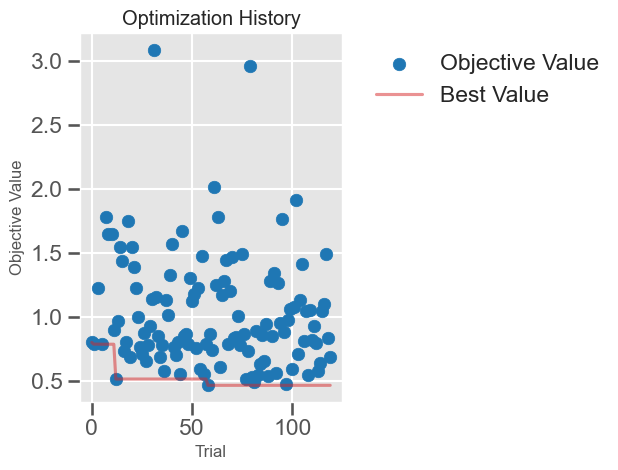

C:\Users\khali\AppData\Local\Temp\ipykernel_19712\2876104006.py:93: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)
[W 2025-05-09 21:11:11,283] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2025-05-09 21:11:11,284] Trial 4 is omitted in visualization because its objective value is inf or nan.
[W 2025-05-09 21:11:11,285] Trial 6 is omitted in visualization because its objective value is inf or nan.
[W 2025-05-09 21:11:11,286] Trial 9 is omitted in visualization because its objective value is inf or nan.


<Figure size 1000x600 with 0 Axes>

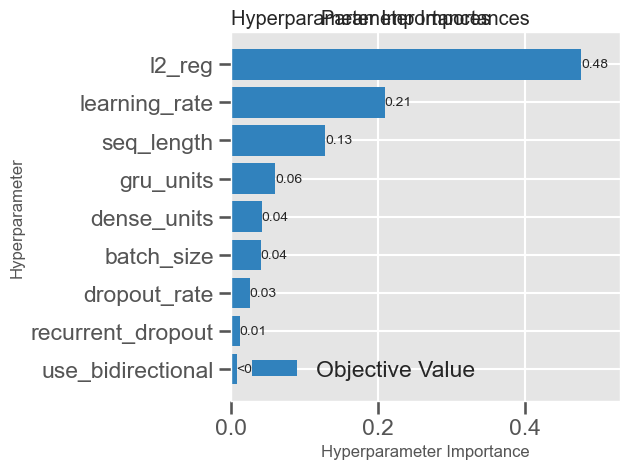


Training model with best parameters...
X_train shape: (22, 21, 10), y_train shape: (22, 10)
X_test shape: (6, 21, 10), y_test shape: (6, 10)
exog_train shape: (22, 1), exog_test shape: (6, 1)


Model: "functional_120"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequence_input (InputLayer)   │ (None, 21, 10)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_33              │ (None, 21, 466)           │         342,510 │ sequence_input[0][0]       │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_120       │ (None, 21, 466)           │             932 │ bidirectional_33[0][0]     │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ exog_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_240 (Dropout)         │ (None, 21, 466)           │               0 │ layer_normalization_120[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_482 (Dense)             │ (None, 8)                 │              16 │ exog_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_layer               │ (None, 466)               │             466 │ dropout_240[0][0]          │
│ (AttentionLayer)              │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_360       │ (None, 8)                 │              32 │ dense_482[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_120 (Concatenate) │ (None, 474)               │               0 │ attention_layer[0][0],     │
│                               │                           │                 │ batch_normalization_360[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_483 (Dense)             │ (None, 81)                │          38,475 │ concatenate_120[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_361       │ (None, 81)                │             324 │ dense_483[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_241 (Dropout)         │ (None, 81)                │               0 │ batch_normalization_361[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_484 (Dense)             │ (None, 40)                │           3,280 │ dropout_241[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_362       │ (None, 40)                │             160 │ dense_484[0][0]            │
│ (BatchNormalization)          │                           │               

 Total params: 386,605 (1.47 MB)

 Trainable params: 386,347 (1.47 MB)

 Non-trainable params: 258 (1.01 KB)

Epoch 1/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - loss: 2.1940 - mae: 1.1449 - root_mean_squared_error: 1.4745
Epoch 1: val_loss improved from inf to 1.20350, saving model to checkpoints_20250509-211112\model_01_1.2035.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - loss: 2.1940 - mae: 1.1449 - root_mean_squared_error: 1.4745 - val_loss: 1.2035 - val_mae: 0.9367 - val_root_mean_squared_error: 1.0880 - learning_rate: 2.6976e-04
Epoch 2/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 2.0221 - mae: 1.1394 - root_mean_squared_error: 1.4151
Epoch 2: val_loss improved from 1.20350 to 1.16669, saving model to checkpoints_20250509-211112\model_02_1.1667.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2.0221 - mae: 1.1394 - root_mean_squared_error: 1.4151 - val_loss: 1.1667 - val_mae: 0.9235 - val_root_mean_squared_error: 1.0710 - learning_rate: 2.6976e-04
Epoch 3/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - loss: 1.9114 - mae: 1.0747 - root_mean_squared_error: 1.3754
Epoch 3: val_loss impr

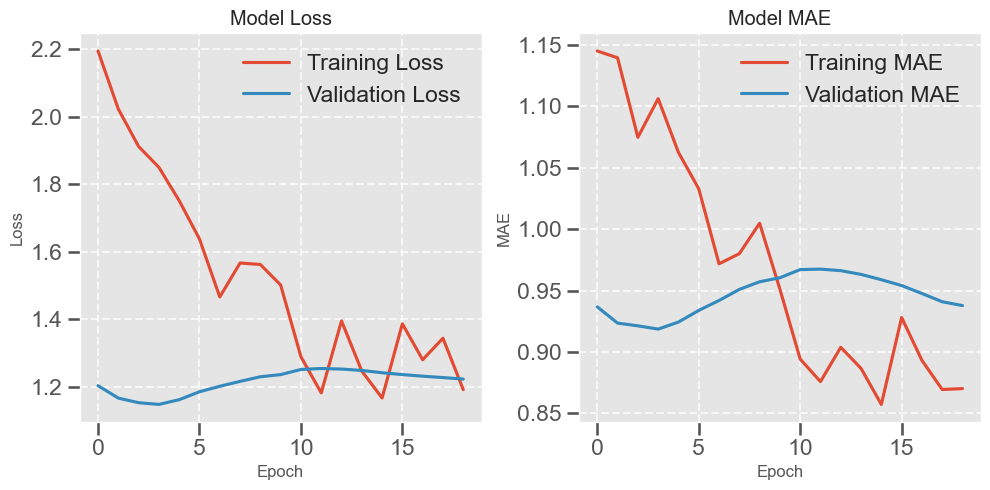

Loaded best model from checkpoint: checkpoints_20250509-211112\model_04_1.1480.keras
Best parameters saved to 'results/best_params.json'
Model saved to 'results/final_model.keras'

Execution time: 2824.96 seconds (47.08 minutes)

Running evaluation and forecasting phase...
Loading model and parameters for evaluation and forecasting
Loaded best parameters from 'results/best_params.json'
Loaded model from 'results/final_model.keras'
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Metrics for IDE(USD):
MSE: 678380308555199872.0000, RMSE: 823638457.4285, MAE: 592078229.3333, R²: -0.4516, MAPE: 22.88%, TS: 0.6660


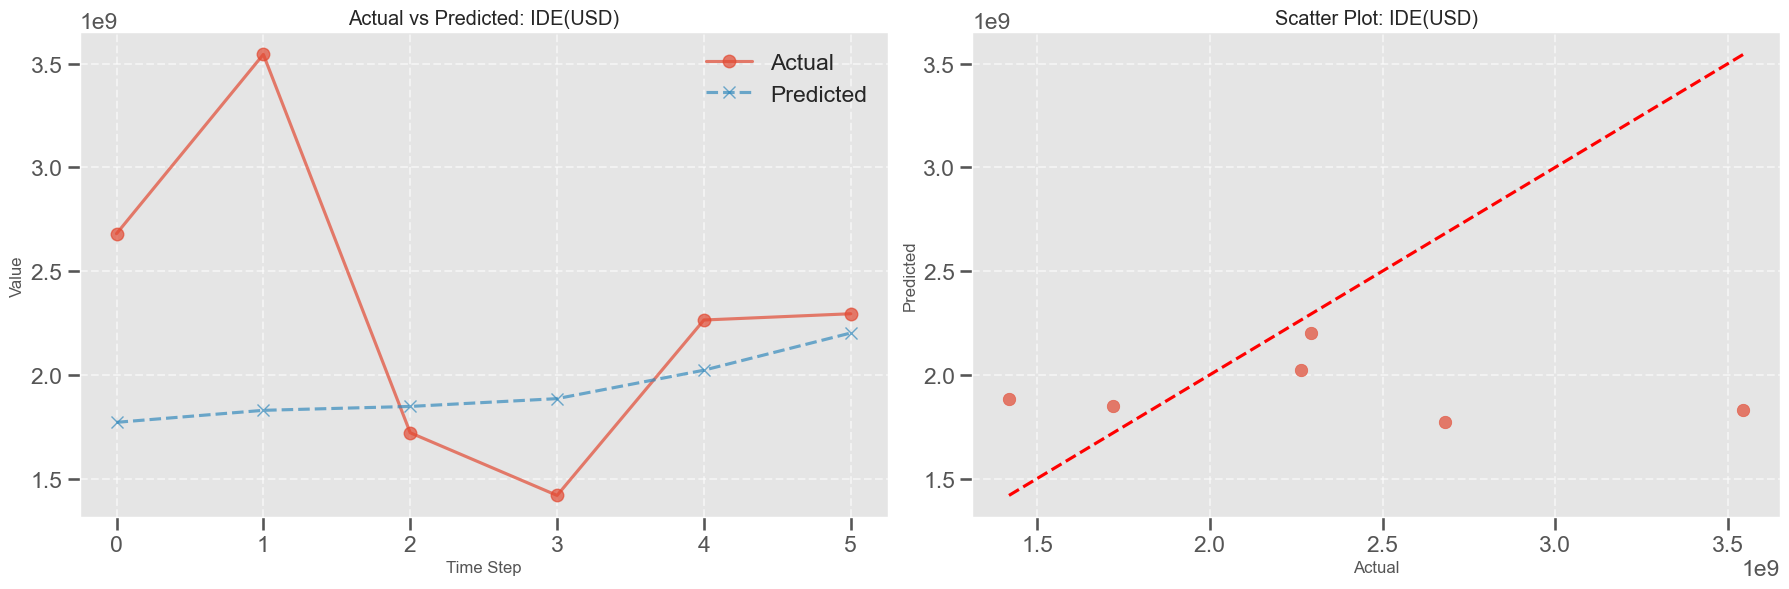


Metrics for REER(2010 = 100):
MSE: 926.3515, RMSE: 30.4360, MAE: 27.3412, R²: -413.5442, MAPE: 27.35%, TS: -1.0000


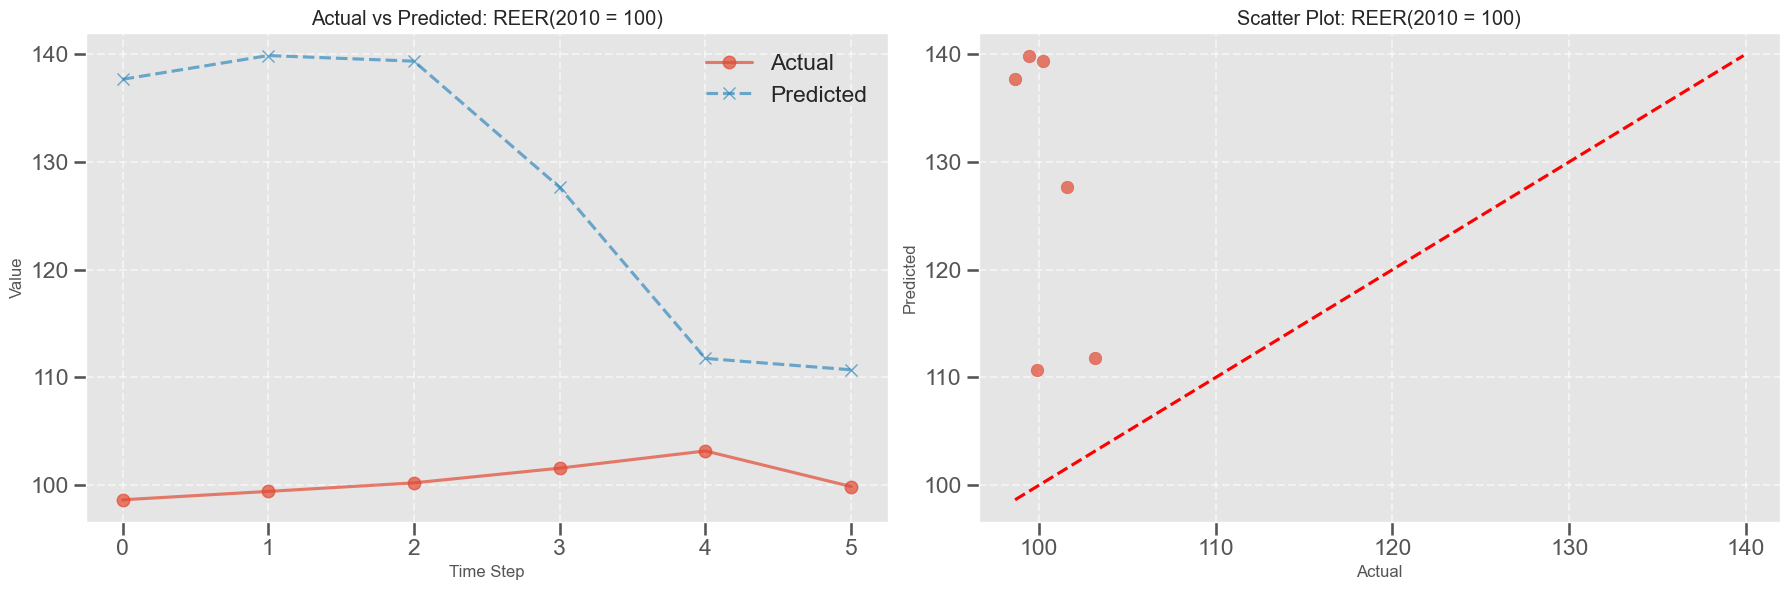


Metrics for mean_brent_oil_prices(USD/barrel):
MSE: 1473.7427, RMSE: 38.3894, MAE: 35.5597, R²: -4.0742, MAPE: 1208116.99%, TS: 0.9321


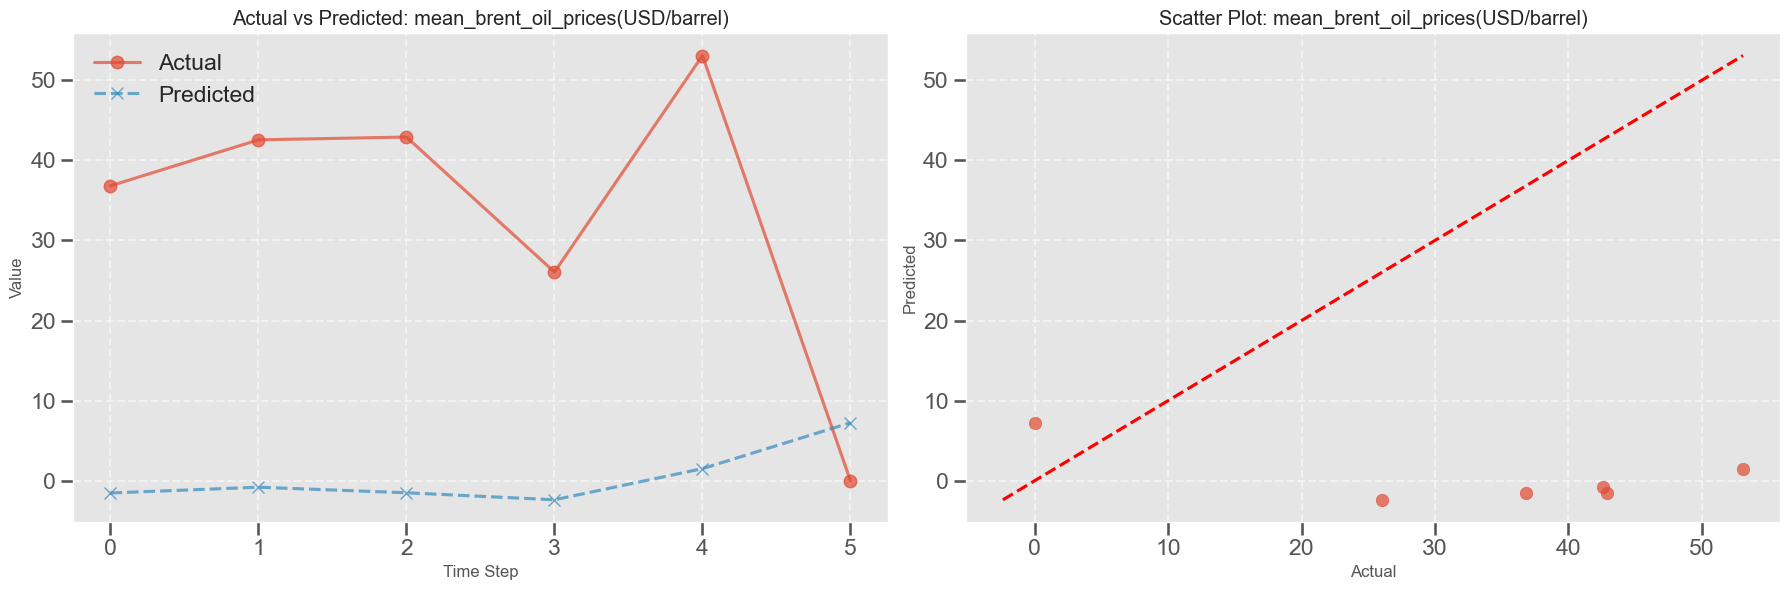


Metrics for mean_crude_oil_prices(USD/barrel):
MSE: 4274.7374, RMSE: 65.3815, MAE: 63.3899, R²: -18.5395, MAPE: 103.58%, TS: 1.0000


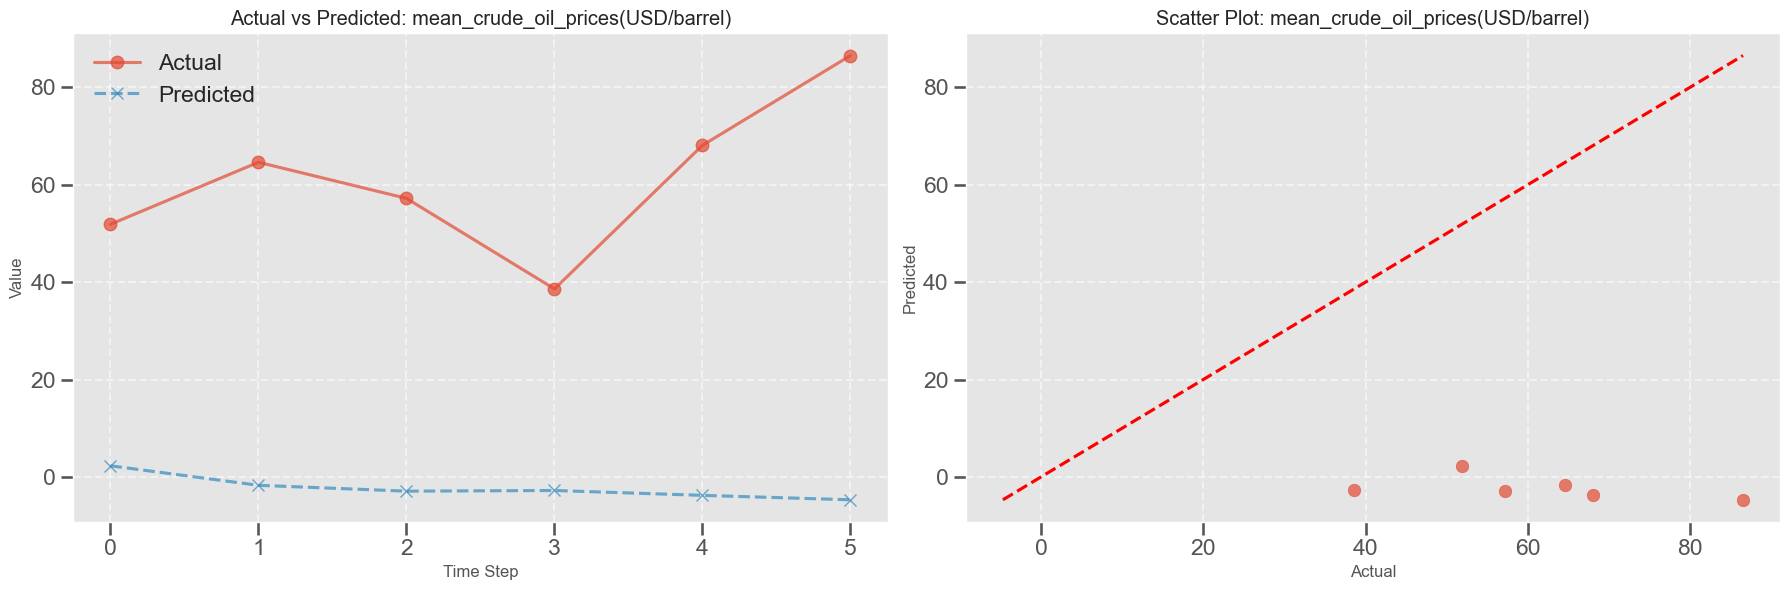


Metrics for mean_daily_natural_gas_prices(USD/MMBtu):
MSE: 5.2480, RMSE: 2.2908, MAE: 2.1842, R²: -7.0274, MAPE: 443097.82%, TS: 1.0000


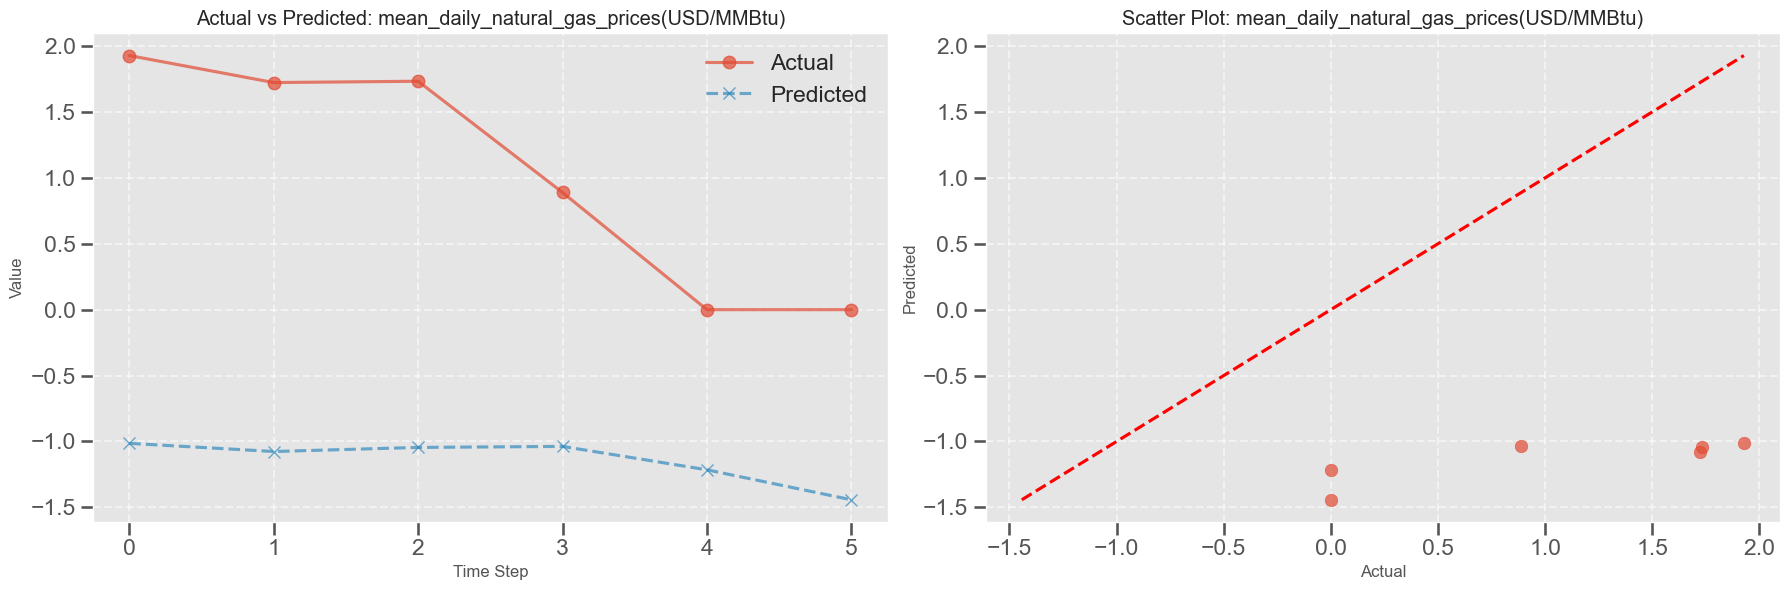


Metrics for annual_gold_prices(USD/oz):
MSE: 420165.6150, RMSE: 648.2018, MAE: 629.0424, R²: 0.0642, MAPE: 384517545.50%, TS: -0.2225


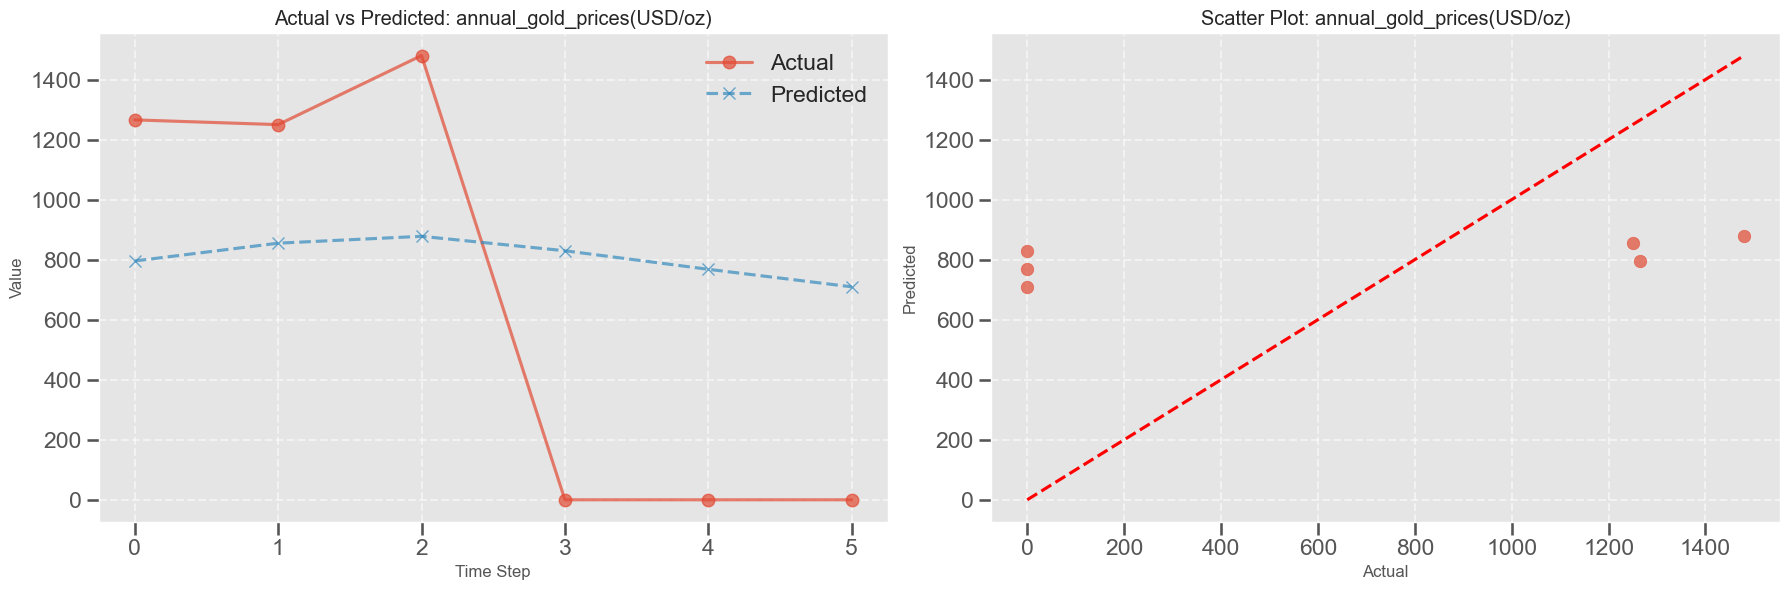


Metrics for InterTourismeReceipts(usd):
MSE: 25764057250686414848.0000, RMSE: 5075830695.6287, MAE: 4191089066.6667, R²: -6.0675, MAPE: 46.17%, TS: 1.0000


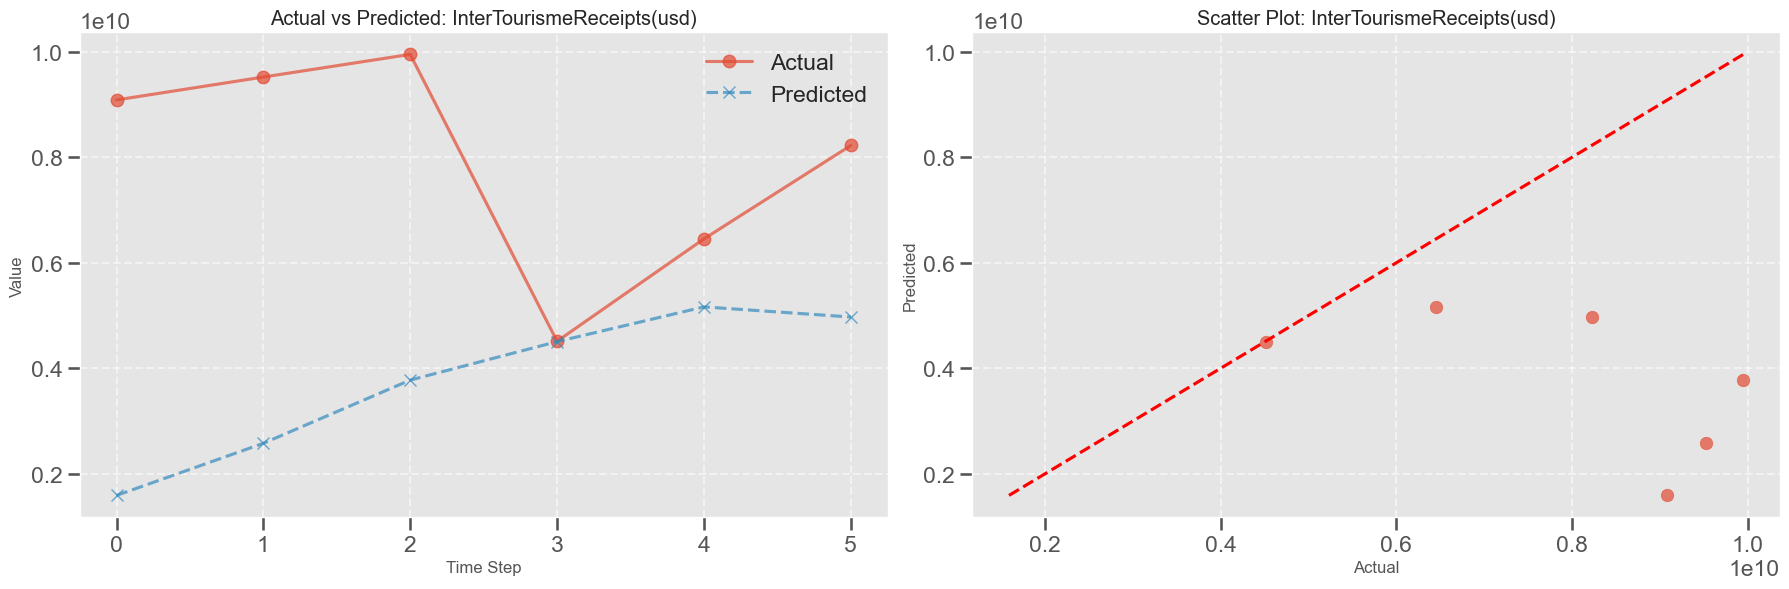


Metrics for Exportation de biens et de services ($ US):
MSE: 808409960214589210624.0000, RMSE: 28432551067.6511, MAE: 26265406634.6667, R²: -15.4696, MAPE: 56.63%, TS: 1.0000


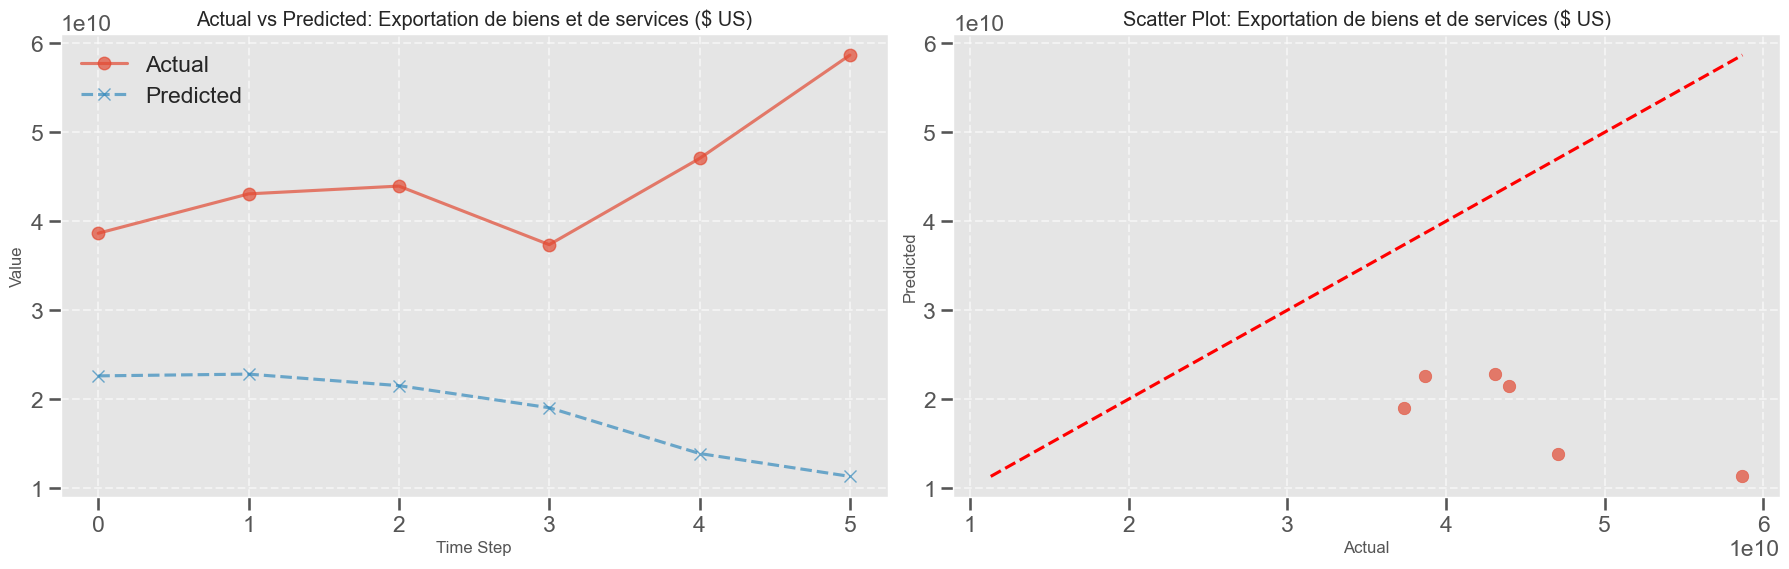


Metrics for Importation de bien et de services ($ US):
MSE: 1248263524679508819968.0000, RMSE: 35330773055.2207, MAE: 33583592106.6667, R²: -14.6772, MAPE: 58.13%, TS: 1.0000


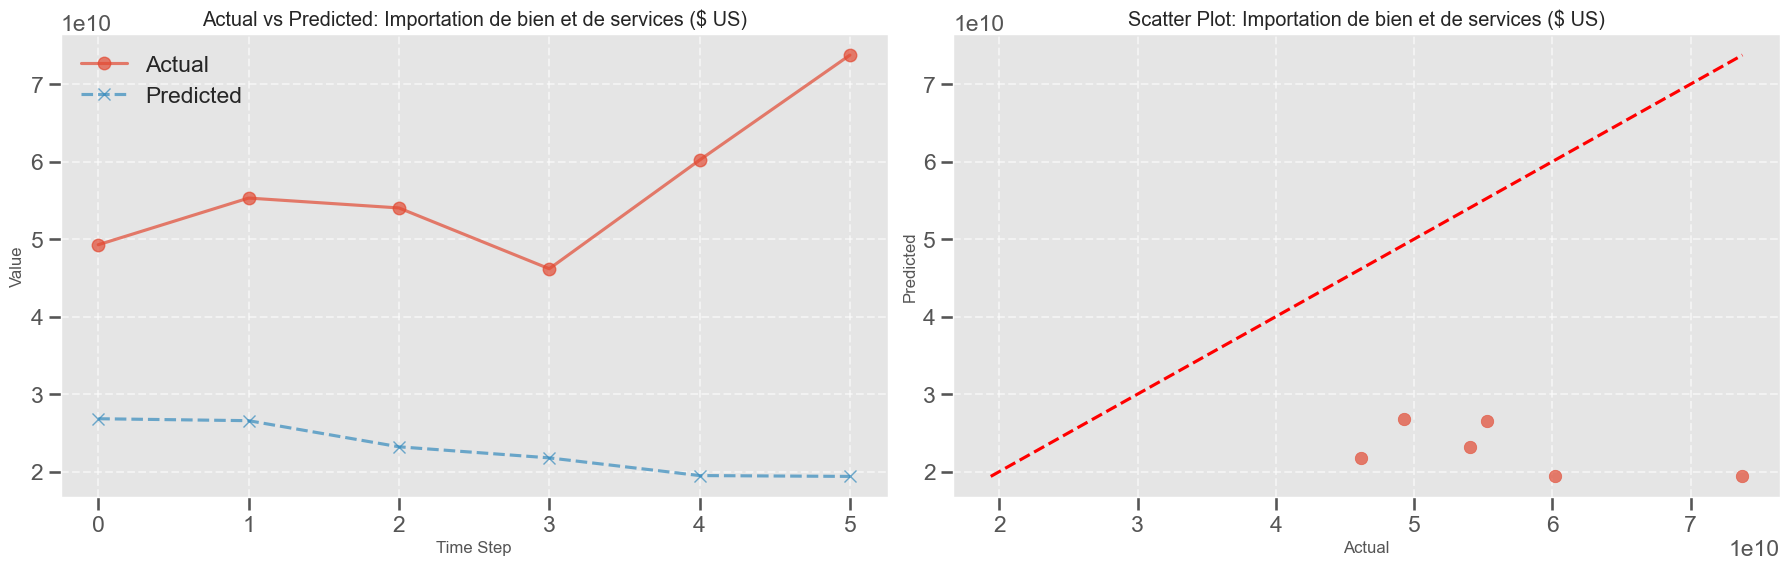


Metrics for Dépenses nationales brutes (unités de devises locales courantes):
MSE: 1010996616267904726335488.0000, RMSE: 1005483274981.6899, MAE: 1003353877162.6666, R²: -140.0893, MAPE: 75.30%, TS: 1.0000


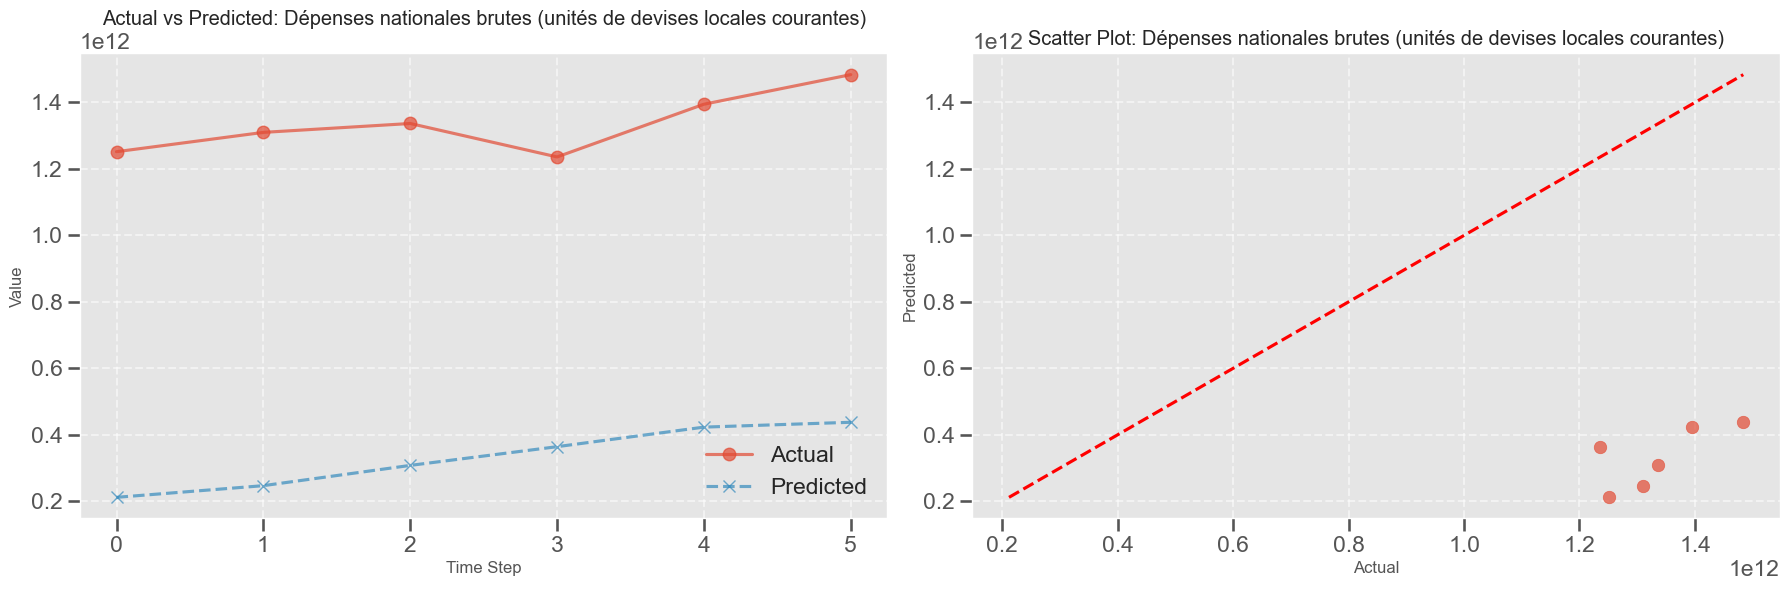


Metrics Summary:
                                                       Indicator          MSE         RMSE          MAE          R²     MAPE (%)  Tracking Signal
                                                        IDE(USD) 6.783803e+17 8.236385e+08 5.920782e+08   -0.451646 2.288228e+01         0.665973
                                                REER(2010 = 100) 9.263515e+02 3.043602e+01 2.734116e+01 -413.544194 2.734507e+01        -1.000000
                               mean_brent_oil_prices(USD/barrel) 1.473743e+03 3.838936e+01 3.555968e+01   -4.074165 1.208117e+06         0.932056
                               mean_crude_oil_prices(USD/barrel) 4.274737e+03 6.538148e+01 6.338989e+01  -18.539475 1.035766e+02         1.000000
                        mean_daily_natural_gas_prices(USD/MMBtu) 5.247974e+00 2.290846e+00 2.184243e+00   -7.027396 4.430978e+05         1.000000
                                      annual_gold_prices(USD/oz) 4.201656e+05 6.482018e+02 6.290424e+02   

C:\Users\khali\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


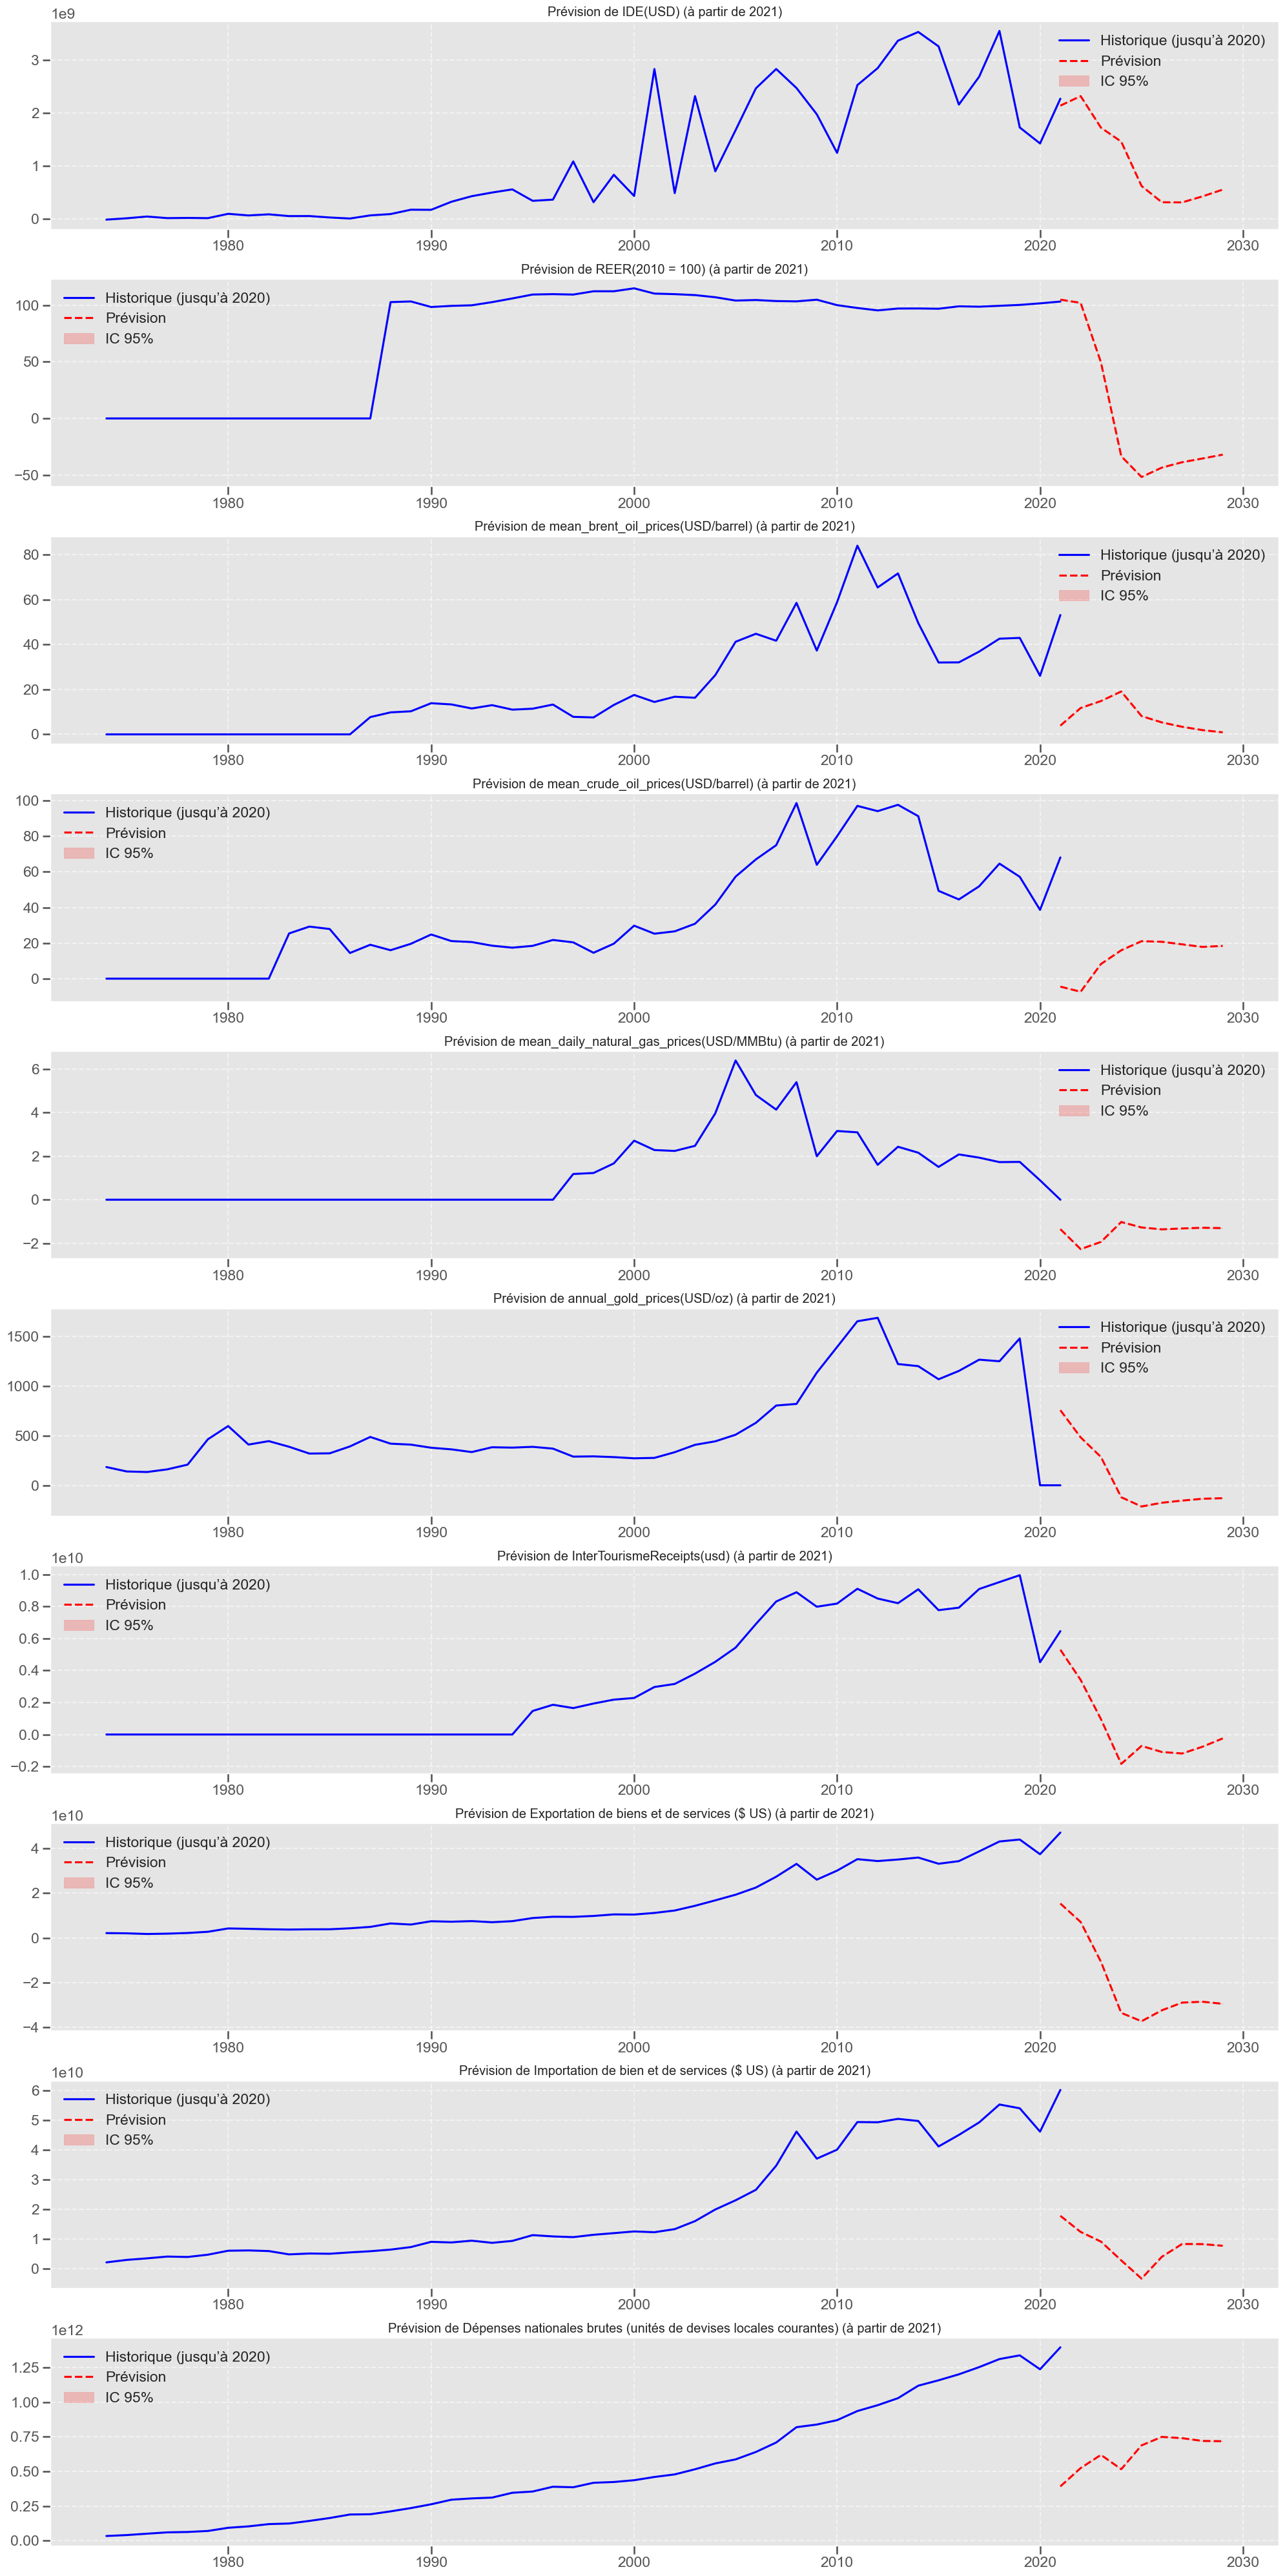


Execution time: 2875.69 seconds (47.93 minutes)
Pipeline completed successfully!


In [251]:


### 4. Exemple d'utilisation

if __name__ == "__main__":
    import pandas as pd
    import numpy as np
    
    # Exemple : Créer des données synthétiques pour démonstration
    # Dans un scénario réel, vous chargeriez vos données depuis un fichier ou une base de données
    
    # Générer des dates
    dates = pd.date_range(start='2020-01-01', periods=500, freq='D')
    
    # Générer des indicateurs synthétiques
    np.random.seed(42)
    
    # Créer un DataFrame avec plusieurs indicateurs
    df = pd.DataFrame({
        'date': dates,
        'indicator1': np.sin(np.linspace(0, 10*np.pi, 500)) + np.random.normal(0, 0.2, 500),
        'indicator2': np.cos(np.linspace(0, 8*np.pi, 500)) + np.random.normal(0, 0.3, 500) + 2,
        'indicator3': np.cumsum(np.random.normal(0, 0.1, 500)) + 10,
        'event': np.random.choice([0, 1], size=500, p=[0.9, 0.1])  # Indicateur d'événement binaire
    })
    
    # Utiliser la date comme index
    df = df.set_index('date')
    
    # Définir les indicateurs à prévoir
    indicator_list = economic_indicators 
    
    # Option 1: Exécuter le pipeline complet (optimisation + prévision)
    metrics, forecasts, best_params = main(
        df=df_annual,
        indicator_list=indicator_list, 
        exog_col='event',
        n_trials=120,
        forecast_steps=10,
        only_forecast=False,
        save_path='results'
    )
    
    
    print("Pipeline completed successfully!")